# Final Project for Stochastic Hydrology: High Flows 
Spring 2021

The purpose of this notebook is to find annual maxima and peaks over threshold for historical and climate change conditions both with and without reservoir operations. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
import utils
from astropy.stats import bootstrap as bootstrap
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats as ss
import scipy.signal
from mk_test import mk_test
import os

## 1. Historical Conditions

In [2]:
files = [f for f in sorted(glob('../Data/baseline*'))]
allQ = pd.DataFrame()
for f in files:
    df = pd.read_csv(f)
    allQ[os.path.basename(f)[:-4]] = df['flow']
allQ.index = pd.to_datetime(df.date)

In [3]:
Objectives = ['Hydropower', 'Environment', 'Recession', 'Sugar', 'Cotton', 'Uncontrolled'] 
colors = ['#999999', "forestgreen", "cornflowerblue", "mediumpurple", "orange", "black"]
col_dict = {'Hydropower':'#999999', 'Environment':'forestgreen', 'Recession':'cornflowerblue', 'Sugar':'mediumpurple', 'Cotton':'orange', 'Uncontrolled':'black'}
allQ.columns = Objectives

### Annual Maxima Series

In [4]:
allQ['Year'] = allQ.index.year
maxQ = allQ.groupby('Year').max()

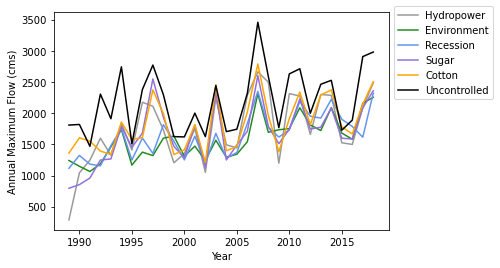

In [5]:
for col in Objectives:
    plt.plot(maxQ.index, maxQ[col], label=col, color=col_dict[col])
plt.legend(bbox_to_anchor=(1,1.05))
plt.xlabel("Year")
plt.ylabel("Annual Maximum Flow (cms)")
plt.show()

Over the historical time period, reservoir operations tend to dampen annual maxima series compared to the uncontrolled scenario. 

### Peaks Over Threshold 

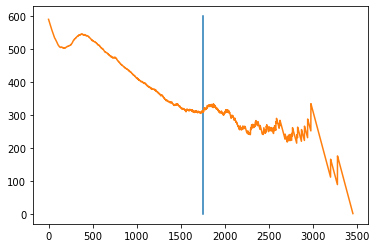

In [6]:
thresholds = np.arange(0,np.max(allQ['Uncontrolled']),1)
y = np.zeros(len(thresholds))
for i in range(len(thresholds)):
    flood_indices = np.where(allQ['Uncontrolled']>thresholds[i])[0]
    y[i] = np.mean(allQ['Uncontrolled'][flood_indices]-thresholds[i])

plt.plot([1750,1750],[0,600])
plt.plot(thresholds,y)

In [7]:
x0 = 1750
# find all peaks over the threshold
peaks = dict.fromkeys(Objectives)
for col in Objectives:
    peaks[col] = np.where(allQ[col]>x0)[0]

In [8]:
# Independent clusters 
# if more than 1 peak over the threshold within 5 days of each other, pick only the largest
allClusters = dict.fromkeys(Objectives)
finalPeaks = dict.fromkeys(Objectives)
for col in Objectives:
    allClusters[col] = []
    subCluster = [peaks[col][0]]
    for i in range(1,len(peaks[col])):
        if peaks[col][i] - peaks[col][i-1] <= 5:
            subCluster.append(peaks[col][i])
        else:
            allClusters[col].append(subCluster)
            subCluster = [peaks[col][i]]

    allClusters[col].append(subCluster)

    finalPeaks[col] = np.zeros(len(allClusters[col]))
    for i in range(len(allClusters[col])):
        finalPeaks[col][i] = np.max(allQ[col][allClusters[col][i]])

In [9]:
finalPeaks

{'Hydropower': array([1837., 2175., 2111., 1801., 1951., 1754., 2245., 2288., 2664.,
        2118., 2023., 2497., 2313., 2276., 1922., 1757., 2137., 1786.,
        2300., 1782., 1947., 2286., 2087., 2488.]),
 'Environment': array([2314., 1753., 2087., 1811., 1766., 2089., 2159., 2255.]),
 'Recession': array([1756., 1811., 1815., 1801., 1834., 2349., 1959., 1772., 2189.,
        1769., 1951., 1921., 1846., 2222., 1769., 1844., 1902., 1787.,
        2322.]),
 'Sugar': array([1788., 2550., 2156., 1936., 1812., 2347., 2604., 1787., 2228.,
        2190., 1775., 1881., 2083., 2084., 2361.]),
 'Cotton': array([1858., 2373., 1982., 1993., 1814., 2458., 2019., 2790., 2042.,
        1822., 1964., 1912., 1812., 2338., 1797., 1783., 2220., 1800.,
        1754., 1818., 1812., 1773., 2291., 1809., 2218., 1783., 2085.,
        2374., 1781., 2143., 1817., 1780., 2506.]),
 'Uncontrolled': array([1809., 1819., 1829., 2306., 1767., 1911., 2744., 1832., 2083.,
        2379., 2772., 2096., 2297., 2049., 20

In [10]:
# what is the average arrival rate, lambda?
llambdas = dict.fromkeys(Objectives)
params = dict.fromkeys(Objectives)
POT_returns = dict.fromkeys(Objectives)

for col in Objectives:
    llambda = len(finalPeaks[col])/len(maxQ)
    llambdas[col] = llambda
    # fit a GPD to the peaks over the threshold
    kappa, x0, alpha = utils.fitGPD(finalPeaks[col], x0, 'MOM')
    params[col] = [kappa, x0, alpha]

    # estimate 100-yr flood
    # find equivalent parameters of GEV
    if kappa == 0:
        xi = x0 + alpha*np.log(llambda)
    else:
        xi = x0 + alpha*(1-llambda**(-kappa))/kappa

    alpha_star = alpha*llambda**(-kappa)

    q_100_POT = utils.findGEVreturnPd(kappa, xi, alpha_star, 100)
    q_500_POT = utils.findGEVreturnPd(kappa, xi, alpha_star, 500)
    POT_returns[col] = [q_100_POT, q_500_POT]

In [11]:
POT_returns

{'Hydropower': [2729.462868835327, 2808.6586135218413],
 'Environment': [2515.870396006432, 2699.99793891264],
 'Recession': [2554.1816534889085, 2950.33803310061],
 'Sugar': [2792.12564899583, 2958.235390297675],
 'Cotton': [3026.57372800514, 3488.873796341829],
 'Uncontrolled': [3729.827779450751, 4306.384844008659]}

### Trend Detection 

#### AMS

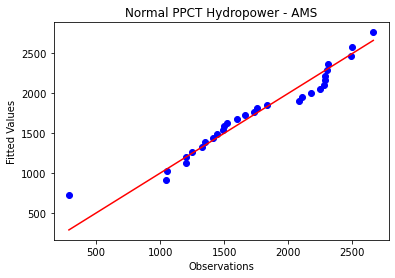

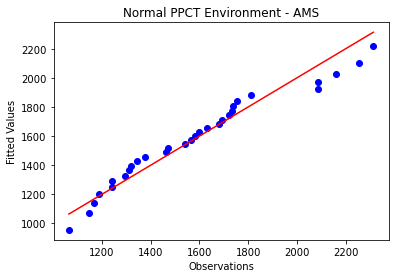

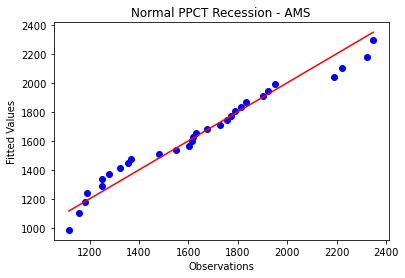

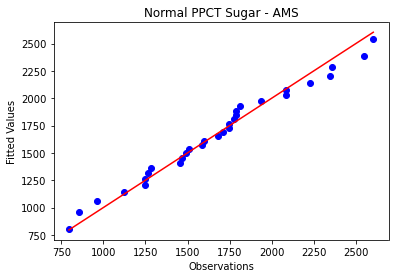

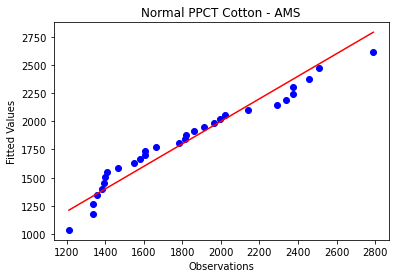

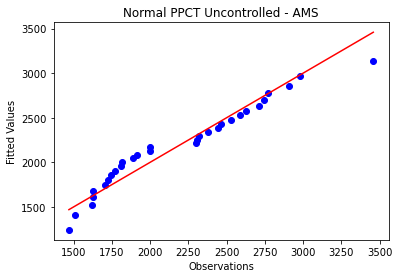

In [12]:
AMS_rhos = dict.fromkeys(Objectives)
AMS_pvals = dict.fromkeys(Objectives)

for col in Objectives:
    mu, sigma = utils.fitNormal(maxQ[col],'MOM')
    rho, p_value = utils.NormalPPCT(maxQ[col], mu, sigma, 'Normal PPCT %s - AMS' % col, '../Figures/AMS_NormalPPCT_%s.png' % col)
    AMS_rhos[col] = rho
    AMS_pvals[col] = p_value

In [13]:
AMS_pvals

{'Hydropower': 0.19069999999999998,
 'Environment': 0.2248,
 'Recession': 0.3972,
 'Sugar': 0.862,
 'Cotton': 0.1763,
 'Uncontrolled': 0.17320000000000002}

All have p-valuse greater than 0.05, so can proceed without transformation. 

#### POT

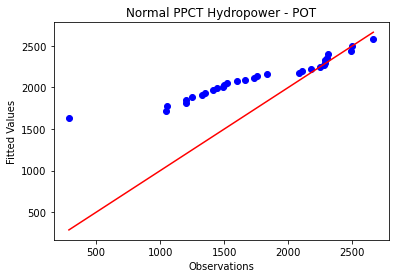

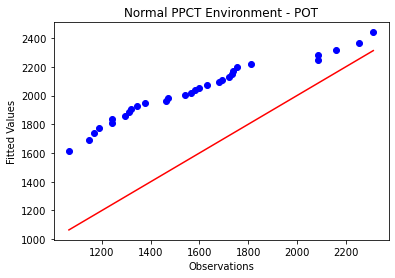

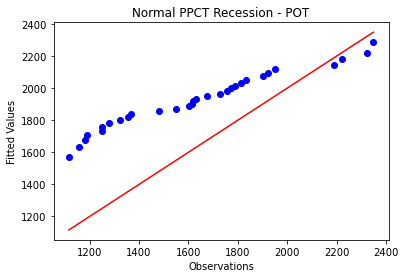

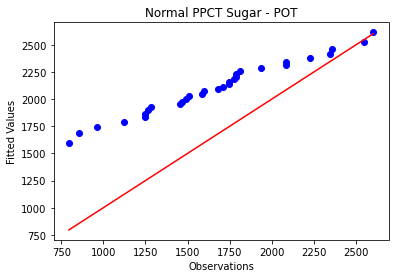

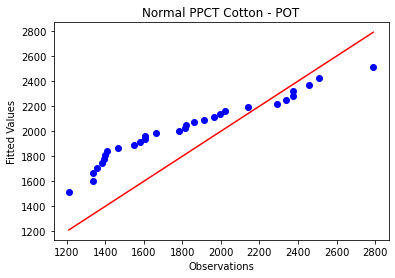

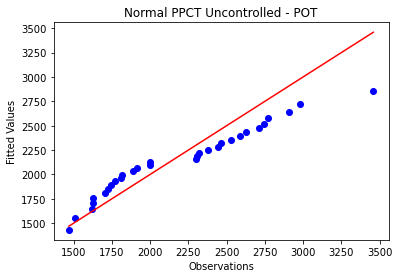

In [14]:
POT_rhos = dict.fromkeys(Objectives)
POT_pvals = dict.fromkeys(Objectives)

for col in Objectives:
    mu, sigma = utils.fitNormal(finalPeaks[col],'MOM')
    rho, p_value = utils.NormalPPCT(maxQ[col], mu, sigma, 'Normal PPCT %s - POT' % col, '../Figures/POT_NormalPPCT_%s.png' % col)
    POT_rhos[col] = rho
    POT_pvals[col] = p_value

In [15]:
POT_pvals

{'Hydropower': 0.18920000000000003,
 'Environment': 0.23660000000000003,
 'Recession': 0.39349999999999996,
 'Sugar': 0.8656,
 'Cotton': 0.17000000000000004,
 'Uncontrolled': 0.16859999999999997}

The QQplots don't look great, but the p-values tells us that we can't reject that the data are normally distributed. 

### Seasonality and Cycles

#### AMS

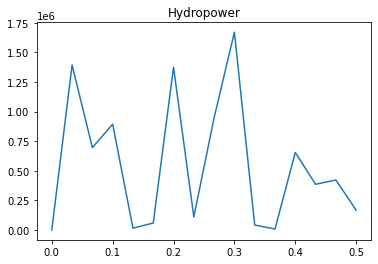

[ 3.33333333 30.          5.          3.75       10.         15.
  2.5         2.14285714  2.30769231  2.          4.28571429  6.
  3.          7.5         2.72727273]


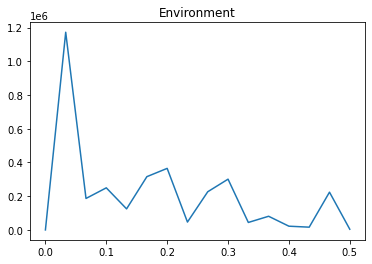

[30.          5.          6.          3.33333333 10.          3.75
  2.14285714 15.          7.5         2.72727273  4.28571429  3.
  2.5         2.30769231  2.        ]


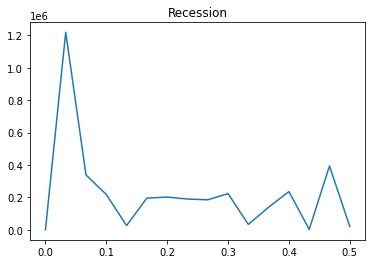

[30.          2.14285714 15.          2.5         3.33333333 10.
  5.          6.          4.28571429  3.75        2.72727273  3.
  7.5         2.          2.30769231]


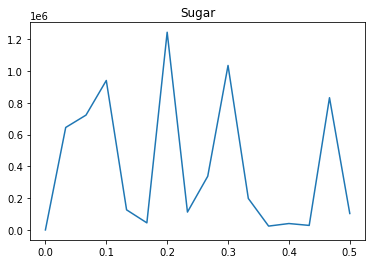

[ 5.          3.33333333 10.          2.14285714 15.         30.
  3.75        3.          7.5         4.28571429  2.          6.
  2.5         2.30769231  2.72727273]


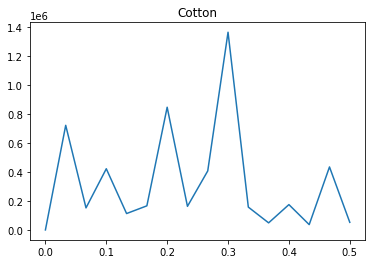

[ 3.33333333  5.         30.          2.14285714 10.          3.75
  2.5         6.          4.28571429  3.         15.          7.5
  2.          2.72727273  2.30769231]


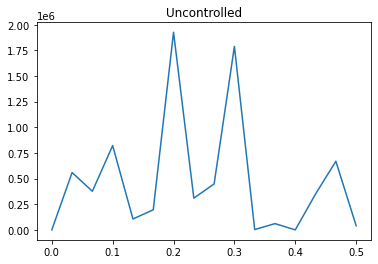

[ 5.          3.33333333 10.          2.14285714 30.          3.75
 15.          2.30769231  4.28571429  6.          7.5         2.72727273
  2.          3.          2.5       ]


In [16]:
# look at periodogram of transformed annual maxima
for col in Objectives:
    f, P = scipy.signal.periodogram(maxQ[col])
    plt.plot(f,P)
    plt.title(col)
    plt.show()

    Psorted = np.argsort(P)[::-1] # sort from largest to smallest
    Psorted = Psorted[Psorted > 0] # filter 0 vals
    T = 1/f[Psorted] # find corresponding periods
    print(T)

<ipython-input-17-bbae9d818295>:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-17-bbae9d818295>:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-17-bbae9d818295>:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-17-bbae9d818295>:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-17-bbae9d818295>:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-17-bbae9d818295>:15: UserWarning: Matplotlib 

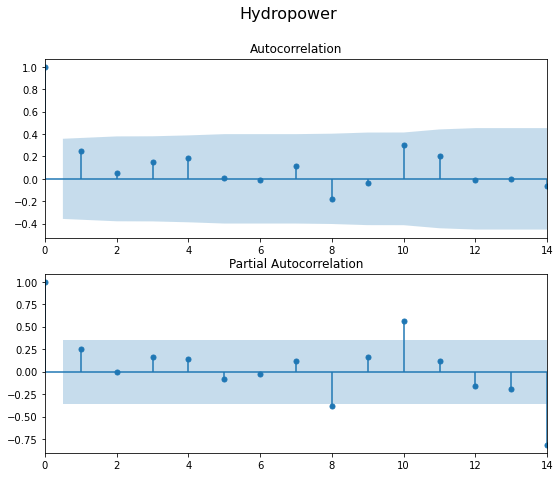

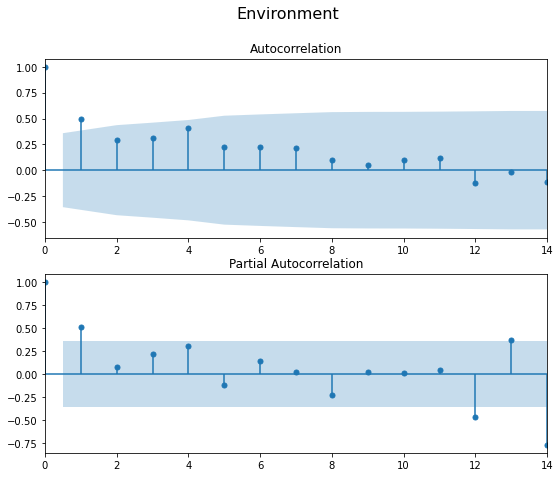

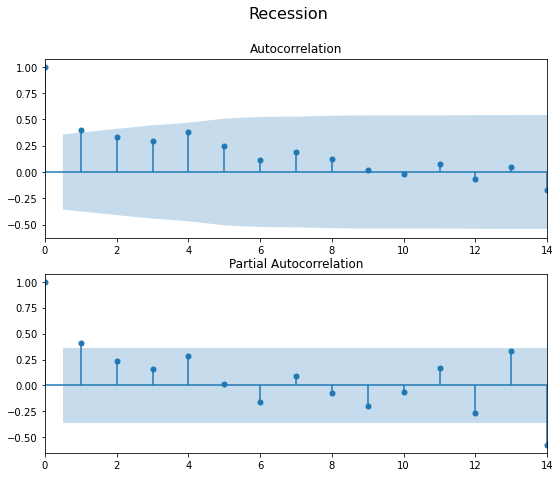

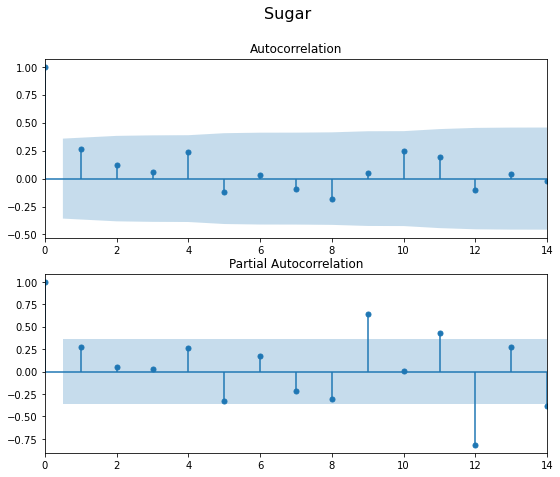

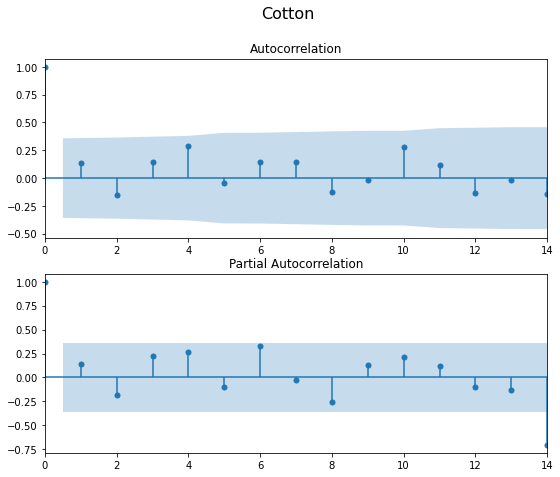

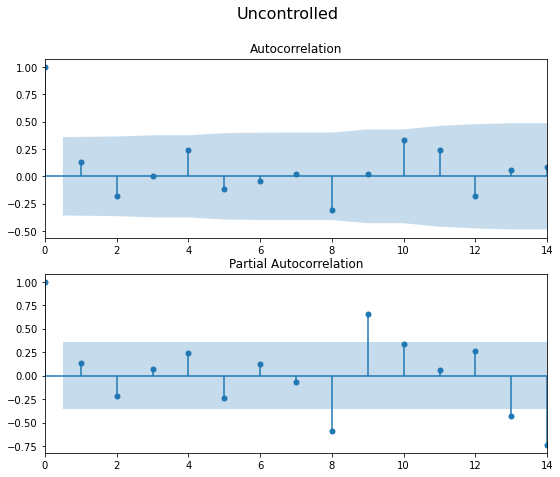

In [17]:
# look at acf and pacf of transformed annual maxima
for col in Objectives:
    fig = plt.figure()
    fig.suptitle(col, fontsize=16)
    ax = fig.add_subplot(2,1,1)
    sm.graphics.tsa.plot_acf(maxQ[col],ax=ax)
    ax.set_xlim([0,14])

    ax = fig.add_subplot(2,1,2)
    sm.graphics.tsa.plot_pacf(maxQ[col],ax = ax, lags=14)
    ax.set_xlim([0,14])

    fig.set_size_inches([9,7.25])
    fig.savefig('../Figures/AMS_historical_ACF_PACF_%s.png' % col)
    fig.show()

Doensn't look like any sesonality or cycles we need to deal with for AMS.

#### POT

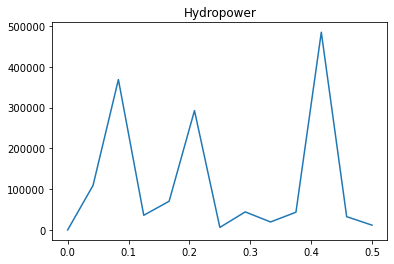

[ 2.4        12.          4.8        24.          6.          3.42857143
  2.66666667  8.          2.18181818  3.          2.          4.        ]


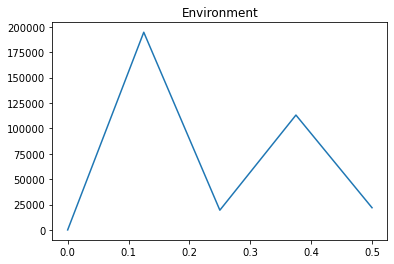

[8.         2.66666667 2.         4.        ]


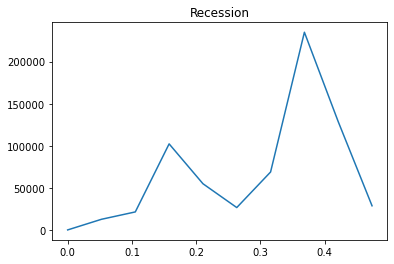

[ 2.71428571  2.375       6.33333333  3.16666667  4.75        2.11111111
  3.8         9.5        19.        ]


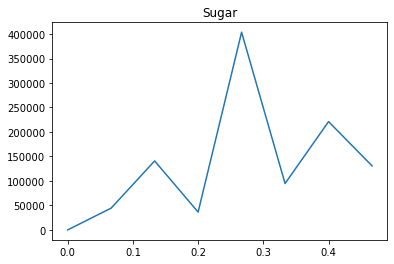

[ 3.75        2.5         7.5         2.14285714  3.         15.
  5.        ]


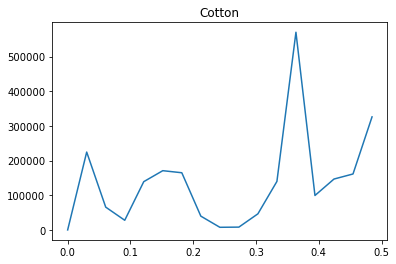

[ 2.75        2.0625     33.          6.6         5.5         2.2
  2.35714286  3.          8.25        2.53846154 16.5         3.3
  4.71428571 11.          3.66666667  4.125     ]


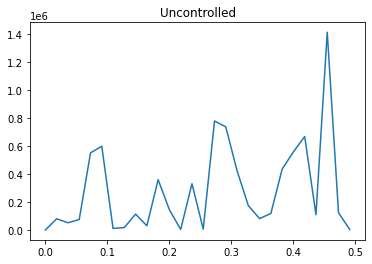

[ 2.2         3.66666667  3.4375      2.39130435 11.          2.5
 13.75        2.61904762  3.23529412  5.5         4.23076923  3.05555556
  5.          2.11538462  2.75        6.875       2.29166667  2.89473684
 55.         18.33333333 27.5         6.11111111  7.85714286  9.16666667
  3.92857143  4.58333333  2.03703704]


In [18]:
# look at periodogram of transformed annual maxima
for col in Objectives:
    f, P = scipy.signal.periodogram(finalPeaks[col])
    plt.plot(f,P)
    plt.title(col)
    plt.show()

    Psorted = np.argsort(P)[::-1] # sort from largest to smallest
    Psorted = Psorted[Psorted > 0] # filter 0 vals
    T = 1/f[Psorted] # find corresponding periods
    print(T)

C:\Users\smj5vup\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
<ipython-input-19-932e9ccbce88>:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-19-932e9ccbce88>:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-19-932e9ccbce88>:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-19-932e9ccbce88>:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-19-932e9ccbce88>:15: UserWarning: Matplotlib is currently usin

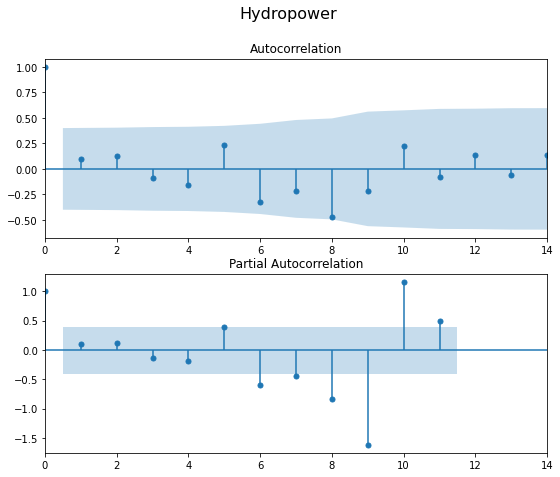

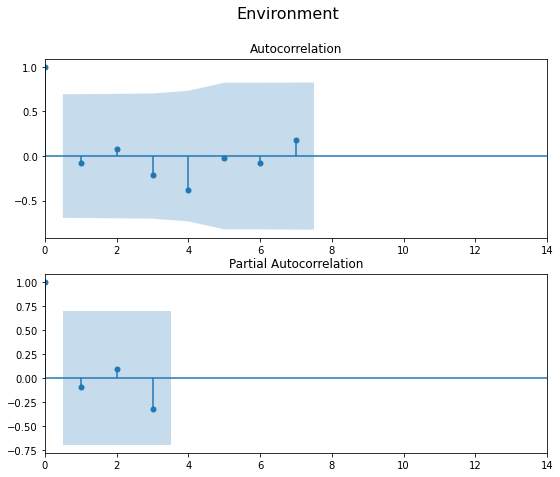

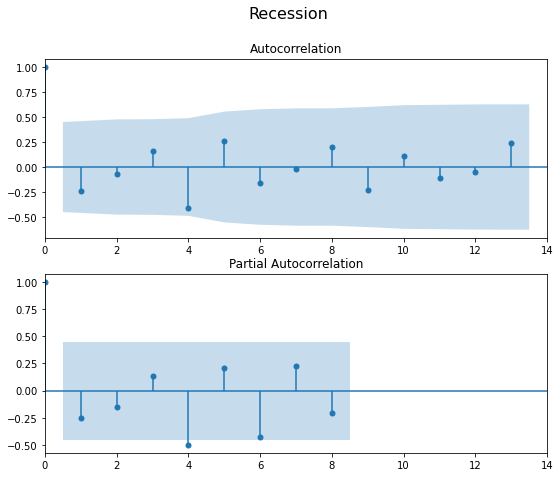

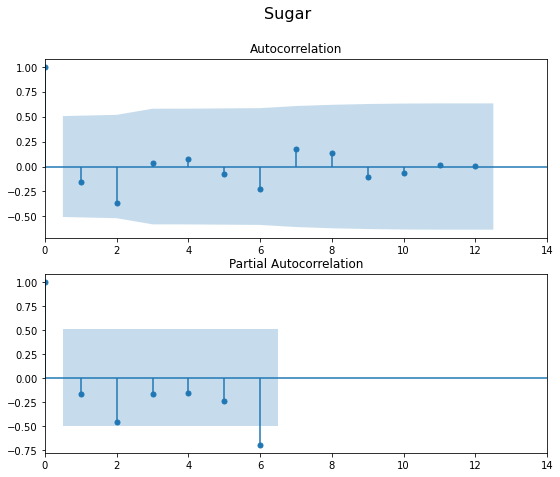

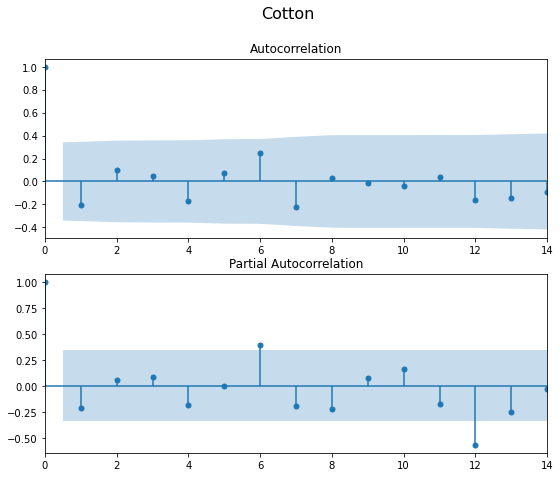

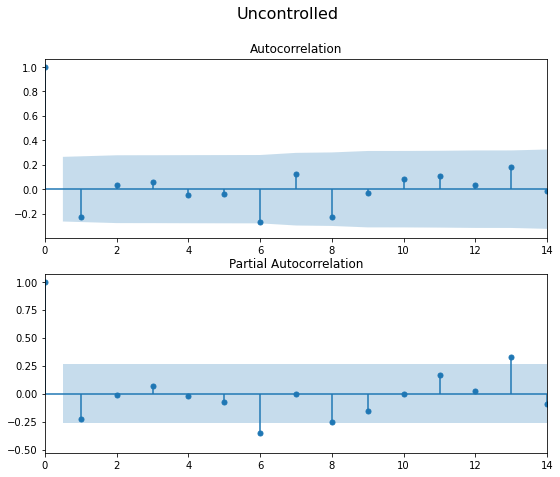

In [19]:
# look at acf and pacf of transformed annual maxima
for col in Objectives:
    fig = plt.figure()
    fig.suptitle(col, fontsize=16)
    ax = fig.add_subplot(2,1,1)
    sm.graphics.tsa.plot_acf(finalPeaks[col],ax=ax)
    ax.set_xlim([0,14])

    ax = fig.add_subplot(2,1,2)
    sm.graphics.tsa.plot_pacf(finalPeaks[col],ax = ax, lags=(len(finalPeaks[col]) /2) - 1)
    ax.set_xlim([0,14])

    fig.set_size_inches([9,7.25])
    fig.savefig('../Figures/POT_historical_ACF_PACF_%s.png' % col)
    fig.show()

Again, no seasonality or cycles apparent here for POT.

### Trend Test

#### AMS

In [20]:
maxQ['Year'] = maxQ.index
mod_dict = dict.fromkeys(Objectives)
for col in Objectives:
    mod = smf.ols(formula='%s ~ Year' %col, data=maxQ)
    result = mod.fit()
    mod_dict[col] = result

In [21]:
for col in Objectives:
    print(col)
    print(mod_dict[col].summary())

Hydropower
                            OLS Regression Results                            
Dep. Variable:             Hydropower   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.266
Method:                 Least Squares   F-statistic:                     11.50
Date:                Thu, 13 May 2021   Prob (F-statistic):            0.00209
Time:                        09:53:17   Log-Likelihood:                -226.30
No. Observations:                  30   AIC:                             456.6
Df Residuals:                      28   BIC:                             459.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -6.602e+04      2e+04     -3.3

##### Hydropower:
* Adj-R2 = 0.291
* p-value = 0.002


##### Environment:
* Adj-R2 = 0.561
* p-value = 0.000

##### Recession:
* Adj-R2 = 0.504
* p-value = 0.000

##### Sugarcane:
* Adj-R2 = 0.287
* p-value = 0.002

##### Cotton:
* Adj-R2 =  0.246
* p-value = 0.005

##### Cotton:
* Adj-R2 =  0.136
* p-value = 0.045

All have a significant trend. Now I can look at the Mann-Kendall test.

In [22]:
AMS_mk_dict = dict.fromkeys(Objectives)
for col in Objectives:
    trend, h, p, z = mk_test(np.array(maxQ[col]))
    AMS_mk_dict[col] = [trend,p]
AMS_mk_dict

{'Hydropower': ['increasing', 0.003849392143958852],
 'Environment': ['increasing', 9.66320208783955e-06],
 'Recession': ['increasing', 3.4864178955151814e-05],
 'Sugar': ['increasing', 0.0013209656271617742],
 'Cotton': ['increasing', 0.00871467247246116],
 'Uncontrolled': ['increasing', 0.025715335933722328]}

All show a significant trend with the Mann Kendall  test as well.

### Potential Change Points

Start with linear model.

In [23]:
lm_pvals = dict.fromkeys(Objectives)


for col in Objectives:
    maxQ['Dummy'] = np.ones(len(maxQ.index))
    p_values = np.ones(len(maxQ.index))
    mod = smf.ols(formula='%s ~ Dummy' % col, data=maxQ)
    result = mod.fit()
    p_values[0] = result.pvalues[1]
    for i in range(len(p_values)):
        maxQ['Dummy'][1989+i] = 0
        mod = smf.ols(formula='%s ~ Dummy' % col, data=maxQ)
        result = mod.fit()
        p_values[i] = result.pvalues[1]
    lm_pvals[col] = p_values

<ipython-input-23-c2123c833532>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maxQ['Dummy'][1989+i] = 0
<ipython-input-23-c2123c833532>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maxQ['Dummy'][1989+i] = 0
<ipython-input-23-c2123c833532>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maxQ['Dummy'][1989+i] = 0
<ipython-input-23-c2123c833532>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

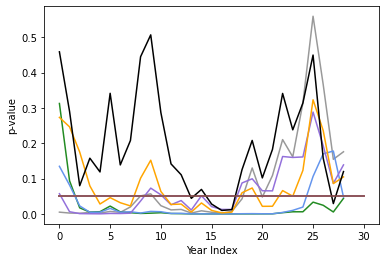

In [24]:
for col in Objectives:
    plt.plot(lm_pvals[col][0:-1], color = col_dict[col])
    plt.plot([0,len(maxQ.index)],[0.05,0.05])
    plt.ylabel("p-value")
    plt.xlabel("Year Index")
plt.show()

Environmental flow and flood recession agriculture policies have statistically significant change poins for most times until the end of the timeseries.

Sugarcane and hydropower are statistically significant until about 2006; same for cotton, but with some non-stat significant around 1998. 

Uncontrolled has a statistically signficiant change points from 2004-2006. 

Now look at the KS test.

In [25]:
ks_pvals = dict.fromkeys(Objectives)
for col in Objectives:
    p_values = np.ones(len(maxQ[col]) -1)
    for i in range(len(maxQ[col]) - 1):
        _, p_values[i] = ss.ks_2samp(maxQ[col].iloc[0:(i+1)],maxQ[col].iloc[(i+1)::])
    ks_pvals[col] = p_values

Hydropower
Environment
Recession
Sugar
Cotton
Uncontrolled


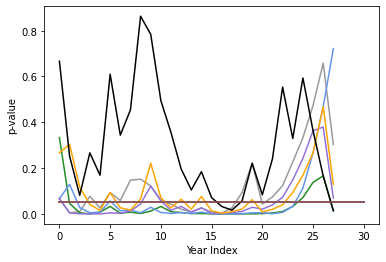

In [26]:
for col in Objectives:
    print(col)
    plt.plot(ks_pvals[col][0:-1], color = col_dict[col])
    plt.plot([0,len(maxQ.index)],[0.05,0.05])
    plt.ylabel("p-value")
    plt.xlabel("Year Index")
plt.show()

Similar change point years identified with KS test.

Now look at Wilcoxon Rank-Sum test

Hydropower
Environment
Recession
Sugar
Cotton
Uncontrolled


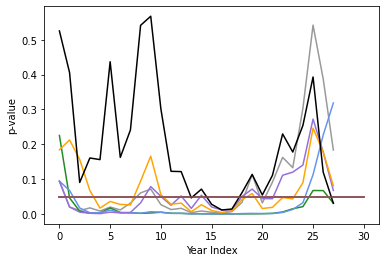

In [27]:
wc_pvals = dict.fromkeys(Objectives)
for col in Objectives:
    p_values = np.ones(len(maxQ[col]) -1)
    for i in range(len(maxQ[col]) - 1):
        _, p_values[i] = ss.ranksums(maxQ[col].iloc[0:(i+1)],maxQ[col].iloc[(i+1)::])
    wc_pvals[col] = p_values
    
for col in Objectives:
    print(col)
    plt.plot(wc_pvals[col][0:-1], color = col_dict[col])
    plt.plot([0,len(maxQ.index)],[0.05,0.05])
    plt.ylabel("p-value")
    plt.xlabel("Year Index")
plt.show()

And again, similar change points identified for Wilcoxon Rank Sum test. 

## 2. Climate Change

Start by reading in the data

In [28]:
gfdl_files = [f for f in sorted(glob('../Data/GFDL*'))]
ccsm4_files = [f for f in sorted(glob('../Data/CCSM4*'))]
GFDL_allQ = pd.DataFrame()
CCSM_allQ = pd.DataFrame()

for g,c in zip(gfdl_files, ccsm4_files):
    df_g = pd.read_csv(g)
    df_c = pd.read_csv(c)
    GFDL_allQ[os.path.basename(g)[:-4]] = df_g['flow']
    CCSM_allQ[os.path.basename(c)[:-4]] = df_c['flow']

GFDL_allQ.index = pd.to_datetime(df_g.date)
CCSM_allQ.index = pd.to_datetime(df_c.date)

CCSM_allQ.columns = Objectives
GFDL_allQ.columns = Objectives

### AMS

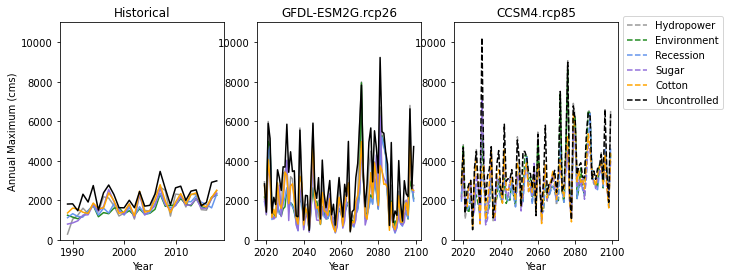

In [29]:
GFDL_allQ['Year'] = GFDL_allQ.index.year 
CCSM_allQ['Year'] = CCSM_allQ.index.year

GFDL_maxQ = GFDL_allQ.groupby('Year').max()
CCSM_maxQ = CCSM_allQ.groupby('Year').max()


fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_size_inches(10,4)
for col in Objectives:
    ax1.plot(maxQ.index, maxQ[col], label=col, color=col_dict[col])
    ax2.plot(GFDL_maxQ.index, GFDL_maxQ[col], label=col, color=col_dict[col])
    ax3.plot(CCSM_maxQ.index, CCSM_maxQ[col], label=col, color=col_dict[col], linestyle='dashed')
    
plt.legend(bbox_to_anchor=(1,1.05))
for ax in [ax1, ax2, ax3]:
    ax.set_xlabel("Year")
    ax.set_ylim(0,11000)
ax1.set_ylabel("Annual Maximum (cms)")
ax1.set_title("Historical")
ax2.set_title("GFDL-ESM2G.rcp26")
ax3.set_title("CCSM4.rcp85")
plt.show()

Annual maxima are often much higher under the climate scenarios compared to historical. The reservoir operations tend to decrease annual maxima compared to an uncontrolled scenario, but do not prevent the flows from reaching much beyond historical levels. 

### Trend Analysis for AMS

Start by checking normality assumption.

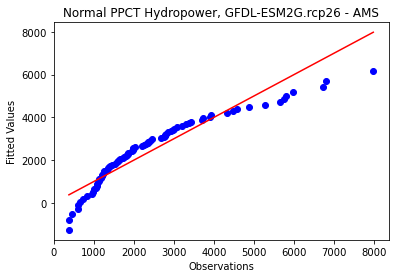

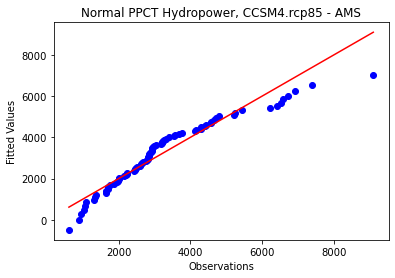

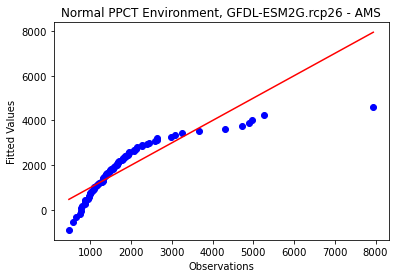

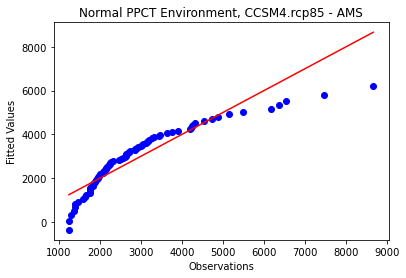

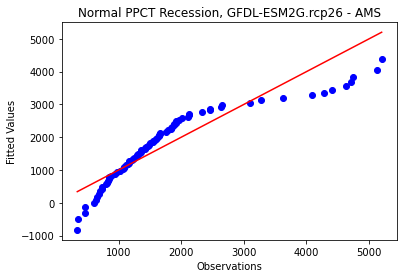

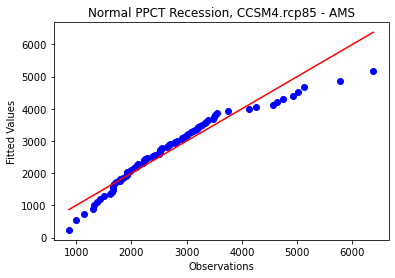

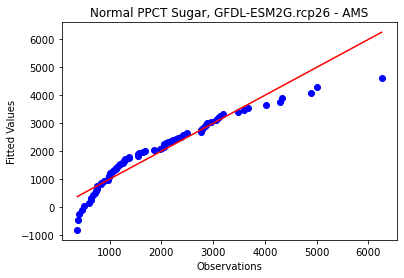

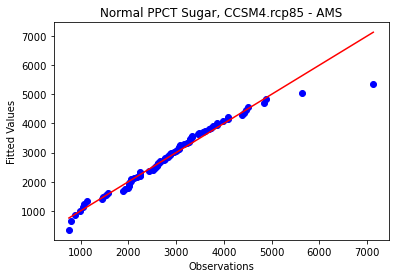

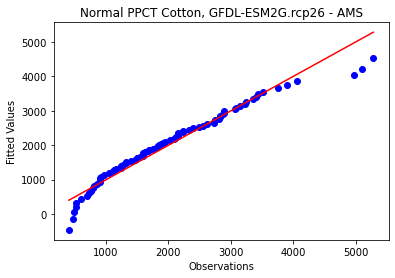

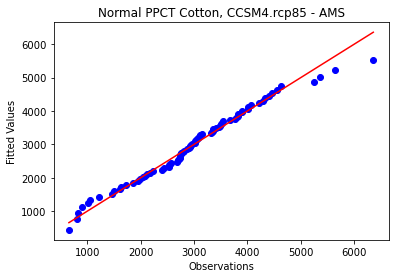

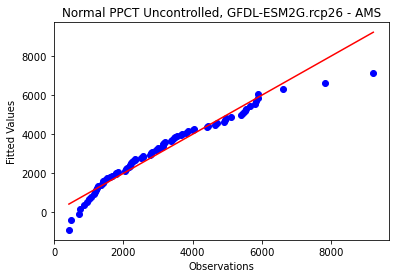

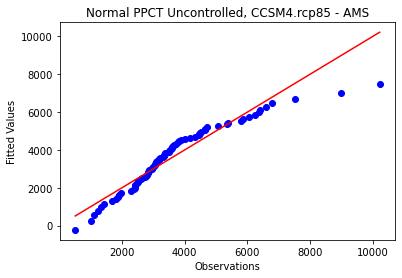

In [30]:
GFDL_rhos = dict.fromkeys(Objectives)
GFDL_p_vals = dict.fromkeys(Objectives)
CCSM_rhos = dict.fromkeys(Objectives)
CCSM_p_vals = dict.fromkeys(Objectives)
for col in Objectives:
    mu, sigma = utils.fitNormal(GFDL_maxQ[col],'MOM')
    rho, p_value = utils.NormalPPCT(GFDL_maxQ[col], mu, sigma, 'Normal PPCT %s, %s' % (col, 'GFDL-ESM2G.rcp26 - AMS'), '../Figures/NormalPPCT_%s_%s_AMS.png'  % (col, 'GFDL-ESM2G.rcp26'))
    GFDL_rhos[col] = rho
    GFDL_p_vals[col] = p_value
    
    mu, sigma = utils.fitNormal(CCSM_maxQ[col],'MOM')
    rho, p_value = utils.NormalPPCT(CCSM_maxQ[col], mu, sigma, 'Normal PPCT %s, %s - AMS' % (col, 'CCSM4.rcp85'), '../Figures/NormalPPCT_%s_%s_AMS.png'  % (col, 'CCSM5.rcp85'))
    CCSM_rhos[col] = rho
    CCSM_p_vals[col] = p_value

In [31]:
print(GFDL_p_vals)
print(CCSM_p_vals)

{'Hydropower': 9.999999999998899e-05, 'Environment': 0.0, 'Recession': 0.0, 'Sugar': 0.0, 'Cotton': 0.011099999999999999, 'Uncontrolled': 0.0038000000000000256}
{'Hydropower': 0.00019999999999997797, 'Environment': 0.0, 'Recession': 0.0004999999999999449, 'Sugar': 0.010700000000000043, 'Cotton': 0.273, 'Uncontrolled': 0.0}


Data needs to be trasnformed. 
Try boxcox transformation first.

In [32]:
GFDL_bc = pd.DataFrame()
CCSM_bc = pd.DataFrame()

GFDL_lambdas = dict.fromkeys(Objectives)
CCSM_lambdas = dict.fromkeys(Objectives)

for col in Objectives:
    Q_T, llambda = ss.boxcox(GFDL_maxQ[col] + 0.1)
    GFDL_lambdas[col] = llambda
    GFDL_bc[col] = Q_T
    Q_T, llambda = ss.boxcox(CCSM_maxQ[col] + 0.1)
    CCSM_bc[col] = Q_T  
    CCSM_lambdas[col] == llambda

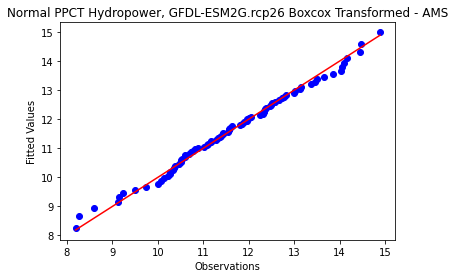

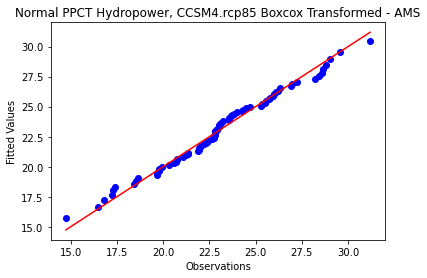

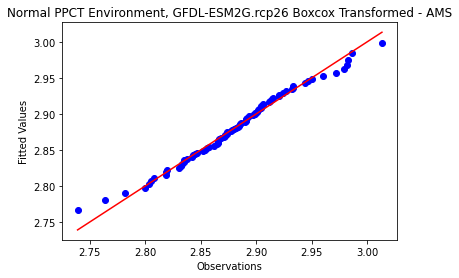

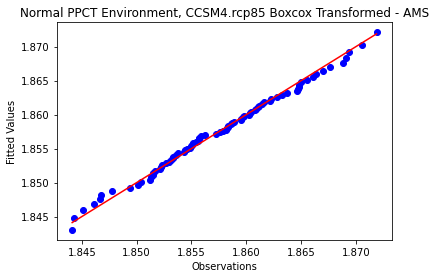

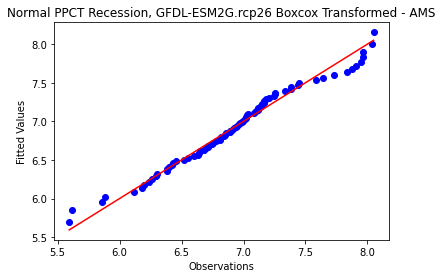

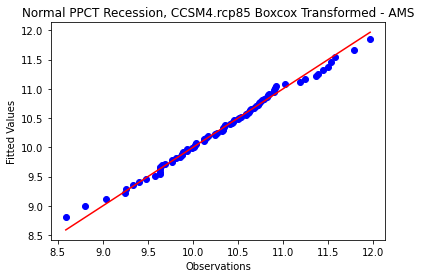

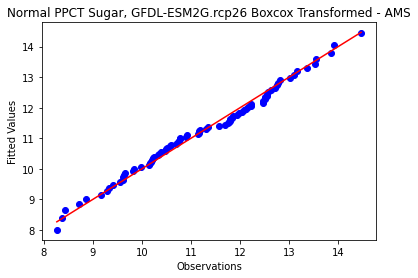

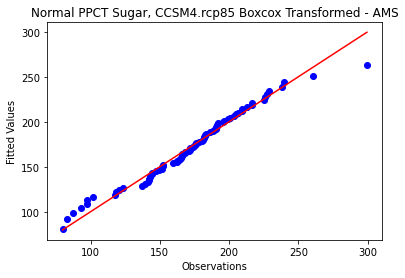

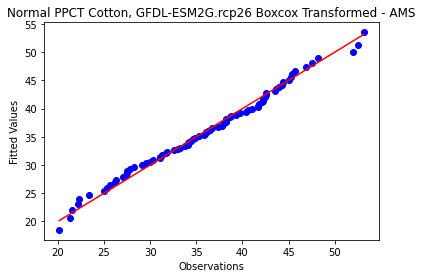

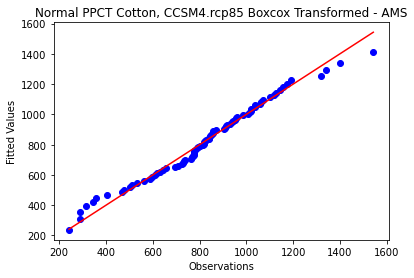

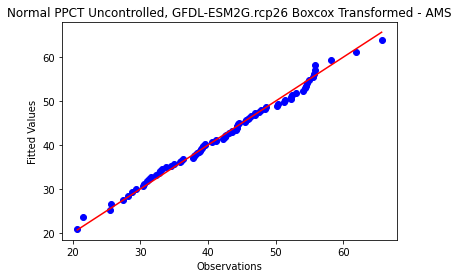

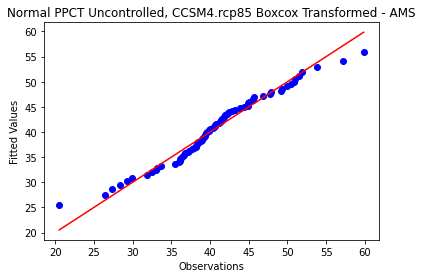

In [33]:
GFDL_bc_rhos = dict.fromkeys(Objectives)
GFDL_bc_p_vals = dict.fromkeys(Objectives)
CCSM_bc_rhos = dict.fromkeys(Objectives)
CCSM_bc_p_vals = dict.fromkeys(Objectives)
for col in Objectives:
    mu, sigma = utils.fitNormal(GFDL_bc[col],'MOM')
    rho, p_value = utils.NormalPPCT(GFDL_bc[col], mu, sigma, 'Normal PPCT %s, %s Boxcox Transformed - AMS' % (col, 'GFDL-ESM2G.rcp26'), '../Figures/NormalPPCT_BC_%s_%s_AMS.png'  % (col, 'GFDL-ESM2G.rcp26'))
    GFDL_bc_rhos[col] = rho
    GFDL_bc_p_vals[col] = p_value
    
    mu, sigma = utils.fitNormal(CCSM_bc[col],'MOM')
    rho, p_value = utils.NormalPPCT(CCSM_bc[col], mu, sigma, 'Normal PPCT %s, %s Boxcox Transformed - AMS' % (col, 'CCSM4.rcp85'), '../Figures/NormalPPCT_BC_%s_%s_AMS.png'  % (col, 'CCSM5.rcp85'))
    CCSM_bc_rhos[col] = rho
    CCSM_bc_p_vals[col] = p_value

In [34]:
print(GFDL_bc_p_vals)
print(CCSM_bc_p_vals)

{'Hydropower': 0.9488, 'Environment': 0.5218, 'Recession': 0.29100000000000004, 'Sugar': 0.7979, 'Cotton': 0.8268, 'Uncontrolled': 0.9396}
{'Hydropower': 0.47350000000000003, 'Environment': 0.9684, 'Recession': 0.8936, 'Sugar': 0.12170000000000003, 'Cotton': 0.34330000000000005, 'Uncontrolled': 0.0635}


Looks great!

#### Test for Trend

Start with linear model.

In [35]:
GFDL_bc['Year'] = GFDL_maxQ.index
CCSM_bc['Year'] = CCSM_maxQ.index

GFDL_mod_dict = dict.fromkeys(Objectives)
CCSM_mod_dict = dict.fromkeys(Objectives)

for col in Objectives:
    mod = smf.ols(formula='%s ~ Year' %col, data=GFDL_bc)
    result = mod.fit()
    GFDL_mod_dict[col] = result
    mod = smf.ols(formula='%s ~ Year' %col, data=CCSM_bc)
    result = mod.fit()
    CCSM_mod_dict[col] = result
    
    
for col in Objectives:
    print(col, "GFDL")
    print(GFDL_mod_dict[col].summary())
    print(col, "CCSM")
    print(CCSM_mod_dict[col].summary())

Hydropower GFDL
                            OLS Regression Results                            
Dep. Variable:             Hydropower   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.012
Method:                 Least Squares   F-statistic:                   0.04820
Date:                Thu, 13 May 2021   Prob (F-statistic):              0.827
Time:                        09:54:04   Log-Likelihood:                -147.11
No. Observations:                  81   AIC:                             298.2
Df Residuals:                      79   BIC:                             303.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.3882     14.740    

##### Hydropower:
* Adj-R2 = -0.009 | 0.067
* p-value = 0.596 | 0.011


##### Environment:
* Adj-R2 = -0.006 | 0.135
* p-value = 0.464 | 0.000

##### Recession:
* Adj-R2 = -0.006 | 0.167
* p-value = 0.470 | 0.000

##### Sugarcane:
* Adj-R2 = -0.009 | 0.058
* p-value = 0.580 | 0.017

##### Cotton:
* Adj-R2 =  -0.013 | 0.079
* p-value = 0.993 | 0.006

##### Uncontrolled:
* Adj-R2 =  0.000 | 0.037
* p-value = 0.324 | 0.047

All have a significant trend for CCSM but not GFDL. Now I can look at the Mann-Kendall test.

In [36]:
GFDL_mk_dict = dict.fromkeys(Objectives)
CCSM_mk_dict = dict.fromkeys(Objectives)

for col in Objectives:
    trend, h, p, z = mk_test(np.array(GFDL_maxQ[col]))
    GFDL_mk_dict[col] = [trend,p]
    trend, h, p, z = mk_test(np.array(CCSM_maxQ[col]))
    CCSM_mk_dict[col] = [trend,p]

In [37]:
print(GFDL_mk_dict)
print(CCSM_mk_dict)

{'Hydropower': ['no trend', 0.9967459114139259], 'Environment': ['no trend', 0.8575801657922097], 'Recession': ['no trend', 0.9739716208231926], 'Sugar': ['no trend', 0.9837306395335426], 'Cotton': ['no trend', 0.8098450082640363], 'Uncontrolled': ['no trend', 0.6419728405725853]}
{'Hydropower': ['increasing', 0.015410154069820825], 'Environment': ['increasing', 6.200999747285607e-05], 'Recession': ['increasing', 0.00011234705549978408], 'Sugar': ['increasing', 0.005548420093199002], 'Cotton': ['increasing', 0.017807646485693107], 'Uncontrolled': ['increasing', 0.028516672774865137]}


Same outcome for Mann Kendall test: no trend for GFDL and increasin trend for CCSM.

#### Change Points

KS test.

Hydropower
Environment
Recession
Sugar
Cotton
Uncontrolled


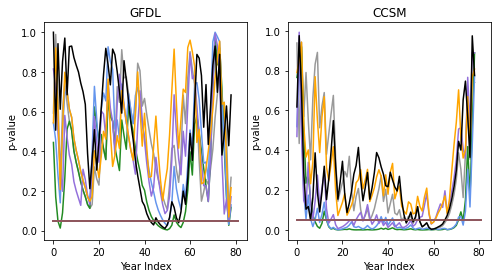

In [38]:
GFDL_ks_pvals = dict.fromkeys(Objectives)
CCSM_ks_pvals = dict.fromkeys(Objectives)

def ks_test(df, col):
    p_values = np.ones(len(df[col]) -1)
    for i in range(len(df[col]) - 1):
        _, p_values[i] = ss.ks_2samp(df[col].iloc[0:(i+1)],df[col].iloc[(i+1)::])
    return p_values

for col in Objectives:
    GFDL_ks_pvals[col] = ks_test(GFDL_maxQ, col)
    CCSM_ks_pvals[col] = ks_test(CCSM_maxQ, col)

fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(8,4)
for col in Objectives:
    print(col)
    ax1.plot(GFDL_ks_pvals[col][0:-1], color = col_dict[col])
    ax1.plot([0,len(GFDL_maxQ.index)],[0.05,0.05])
    ax1.set_ylabel("p-value")
    ax1.set_xlabel("Year Index")
    ax1.set_title("GFDL")
    ax2.plot(CCSM_ks_pvals[col][0:-1], color = col_dict[col])
    ax2.plot([0,len(CCSM_maxQ.index)],[0.05,0.05])
    ax2.set_ylabel("p-value")
    ax2.set_xlabel("Year Index")
    ax2.set_title("CCSM")
plt.show()

GFDL has its most statistically significant change point for uncontrolled and environmental flows at year 2069 and 2070 respectively. The rest of the policies don't exhibit statistically signiciant change points. 

For CCSM, environmnetal flows, recession, and sugarcane have statistically significant change poi sfor many years. Uncontrolled is most significant at 2079; same with cotton and sugar, but these are generally not statistically significant. 

Same for Wilcoxon Rank-Sum Test:

Hydropower
Environment
Recession
Sugar
Cotton
Uncontrolled


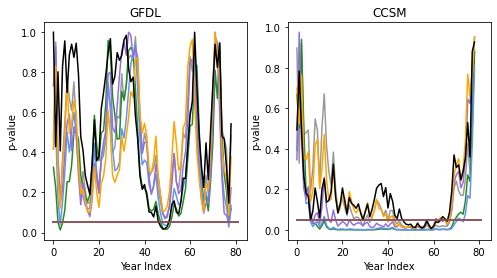

In [39]:
GFDL_wc_pvals = dict.fromkeys(Objectives)
CCSM_wc_pvals = dict.fromkeys(Objectives)

for col in Objectives:
    p_values = np.ones(len(GFDL_maxQ[col]) -1)
    for i in range(len(GFDL_maxQ[col]) - 1):
        _, p_values[i] = ss.ranksums(GFDL_maxQ[col].iloc[0:(i+1)],GFDL_maxQ[col].iloc[(i+1)::])
    GFDL_wc_pvals[col] = p_values
    p_values = np.ones(len(CCSM_maxQ[col]) -1)
    for i in range(len(CCSM_maxQ[col]) - 1):
        _, p_values[i] = ss.ranksums(CCSM_maxQ[col].iloc[0:(i+1)],CCSM_maxQ[col].iloc[(i+1)::])
    CCSM_wc_pvals[col] = p_values    


fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(8,4)
for col in Objectives:
    print(col)
    ax1.plot(GFDL_wc_pvals[col][0:-1], color = col_dict[col])
    ax1.plot([0,len(GFDL_maxQ.index)],[0.05,0.05])
    ax1.set_ylabel("p-value")
    ax1.set_xlabel("Year Index")
    ax1.set_title("GFDL")
    ax2.plot(CCSM_wc_pvals[col][0:-1], color = col_dict[col])
    ax2.plot([0,len(CCSM_maxQ.index)],[0.05,0.05])
    ax2.set_ylabel("p-value")
    ax2.set_xlabel("Year Index")
    ax2.set_title("CCSM")
plt.show()

Similar change points identified. Now try linear model:

In [40]:
GFDL_lm_pvals = dict.fromkeys(Objectives)
CCSM_lm_pvals = dict.fromkeys(Objectives)


for col in Objectives:
    GFDL_maxQ['Dummy'] = np.ones(len(GFDL_maxQ.index))
    p_values = np.ones(len(GFDL_maxQ.index))
    mod = smf.ols(formula='%s ~ Dummy' % col, data=GFDL_maxQ)
    result = mod.fit()
    p_values[0] = result.pvalues[1]
    for i in range(len(p_values)):
        GFDL_maxQ['Dummy'][1989+i] = 0
        mod = smf.ols(formula='%s ~ Dummy' % col, data=GFDL_maxQ)
        result = mod.fit()
        p_values[i] = result.pvalues[1]
    GFDL_lm_pvals[col] = p_values
    

In [41]:
for col in Objectives:
    CCSM_maxQ['Dummy'] = np.ones(len(CCSM_maxQ.index))
    p_values = np.ones(len(CCSM_maxQ.index))
    mod = smf.ols(formula='%s ~ Dummy' % col, data=CCSM_maxQ)
    result = mod.fit()
    p_values[0] = result.pvalues[1]
    for i in range(len(p_values)):
        CCSM_maxQ['Dummy'][1989+i] = 0
        mod = smf.ols(formula='%s ~ Dummy' % col, data=CCSM_maxQ)
        result = mod.fit()
        p_values[i] = result.pvalues[1]
    CCSM_lm_pvals[col] = p_values
    

In [42]:
CCSM_maxQ

Hydropower  Environment  Recession   Sugar  Cotton  Uncontrolled  Dummy
Year                                                                         
2019      2933.0       2158.0     1924.0  2052.0  2746.0        2829.0    0.0
2020      4807.0       4735.0     4130.0  3565.0  4211.0        4659.0    0.0
2021      1064.0       1952.0     1795.0  1582.0  1471.0        1333.0    0.0
2022      1698.0       1593.0     1510.0  1884.0  1639.0        2486.0    0.0
2023      2841.0       1363.0     1655.0  2251.0  2799.0        2812.0    0.0
...          ...          ...        ...     ...     ...           ...    ...
2095      2670.0       2625.0     2680.0  2840.0  2821.0        2996.0    1.0
2096      5252.0       4252.0     4564.0  4092.0  4325.0        6600.0    1.0
2097      3399.0       3443.0     3355.0  2558.0  2680.0        3359.0    1.0
2098      1657.0       1832.0     1714.0  1937.0  1611.0        1900.0    1.0
2099      6520.0       4321.0     4626.0  3985.0  4398.0        6360.0    1.0

[81 rows x 7 columns]

Hydropower
Environment
Recession
Sugar
Cotton
Uncontrolled


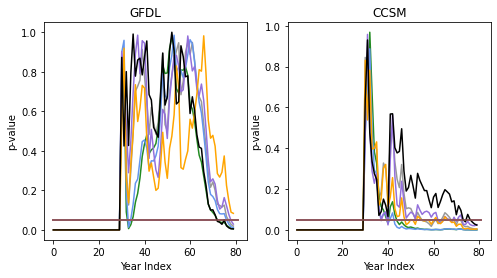

In [43]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(8,4)
for col in Objectives:
    print(col)
    ax1.plot(GFDL_lm_pvals[col][0:-1], color = col_dict[col])
    ax1.plot([0,len(GFDL_maxQ.index)],[0.05,0.05])
    ax1.set_ylabel("p-value")
    ax1.set_xlabel("Year Index")
    ax1.set_title("GFDL")
    ax2.plot(CCSM_lm_pvals[col][0:-1], color = col_dict[col])
    ax2.plot([0,len(CCSM_maxQ.index)],[0.05,0.05])
    ax2.set_ylabel("p-value")
    ax2.set_xlabel("Year Index")
    ax2.set_title("CCSM")
plt.show()

## 3. Full Time Period (1989-2099)

In [44]:
GFDL_allQ = pd.concat([allQ, GFDL_allQ])
CCSM_allQ = pd.concat([allQ, CCSM_allQ])

In [45]:
GFDL_allQ.to_csv('../Data/GFDL_allQ.csv')
CCSM_allQ.to_csv('../Data/CCSM_allQ.csv')

In [46]:
GFDL_allQ['Year'] = GFDL_allQ.index.year
CCSM_allQ['Year'] = CCSM_allQ.index.year
GFDL_maxQ = GFDL_allQ.groupby('Year').max()
CCSM_maxQ = CCSM_allQ.groupby('Year').max()

GFDL_maxQ.to_csv('../Data/GFDL_maxQ.csv')
CCSM_maxQ.to_csv('../Data/CCSM_maxQ.csv')

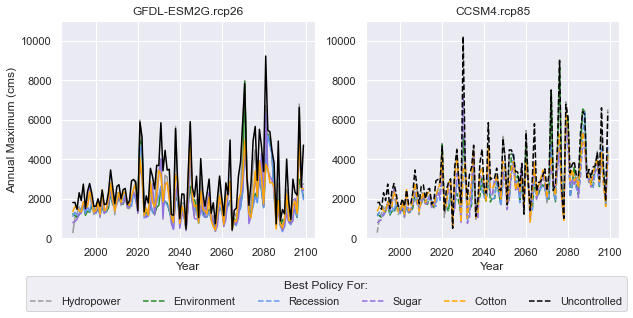

In [77]:
import seaborn as sns
sns.set()
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(10,4)
for col in Objectives:
    ax1.plot(GFDL_maxQ.index, GFDL_maxQ[col], label=col, color=col_dict[col])
    ax2.plot(CCSM_maxQ.index, CCSM_maxQ[col], label=col, color=col_dict[col], linestyle='dashed')
    
plt.legend(ncol = 7, bbox_to_anchor=(1.05,-.15), title="Best Policy For:")
for ax in [ax1, ax2]:
    ax.set_xlabel("Year")
    ax.set_ylim(0,11000)
ax1.set_ylabel("Annual Maximum (cms)")
ax1.set_title("GFDL-ESM2G.rcp26")
ax2.set_title("CCSM4.rcp85")
plt.savefig('../Figures/AMS.png',bbox_inches='tight')
plt.show()

### Trend Detection

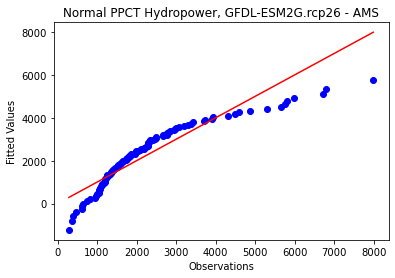

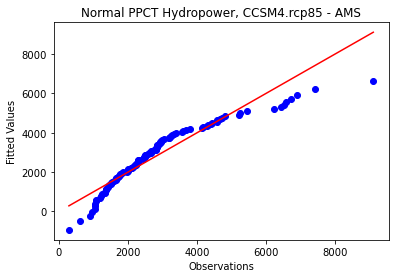

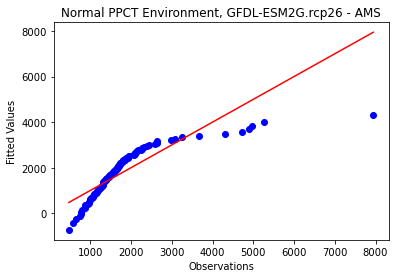

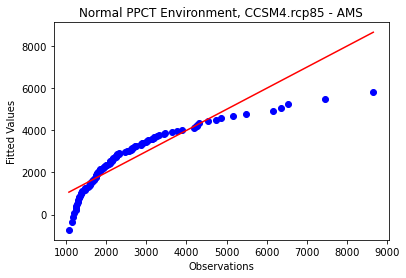

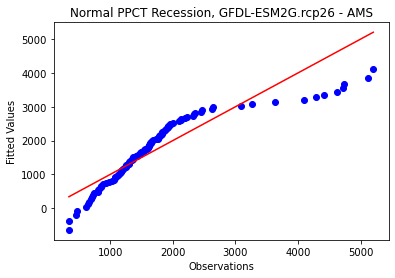

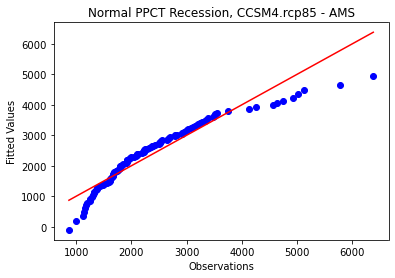

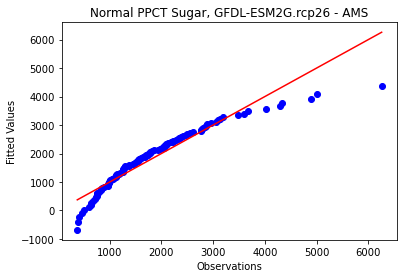

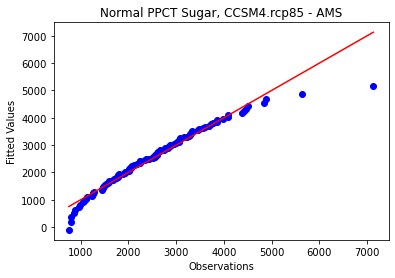

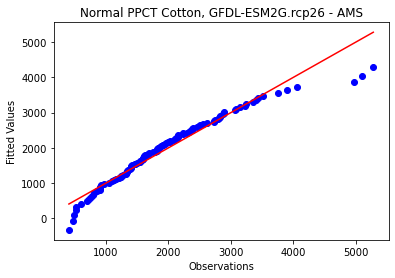

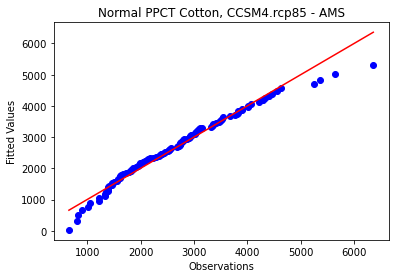

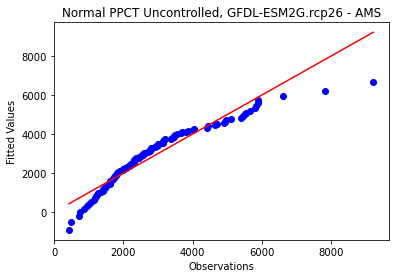

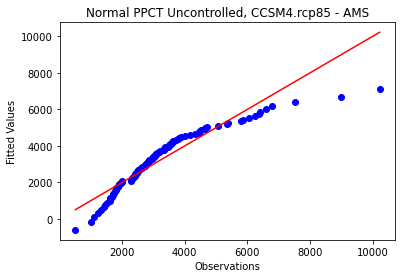

In [47]:
GFDL_rhos = dict.fromkeys(Objectives)
GFDL_p_vals = dict.fromkeys(Objectives)
CCSM_rhos = dict.fromkeys(Objectives)
CCSM_p_vals = dict.fromkeys(Objectives)
for col in Objectives:
    mu, sigma = utils.fitNormal(GFDL_maxQ[col],'MOM')
    rho, p_value = utils.NormalPPCT(GFDL_maxQ[col], mu, sigma, 'Normal PPCT %s, %s' % (col, 'GFDL-ESM2G.rcp26 - AMS'), '../Figures/NormalPPCT_%s_%s_AMSfull.png'  % (col, 'GFDL-ESM2G.rcp26'))
    GFDL_rhos[col] = rho
    GFDL_p_vals[col] = p_value
    
    mu, sigma = utils.fitNormal(CCSM_maxQ[col],'MOM')
    rho, p_value = utils.NormalPPCT(CCSM_maxQ[col], mu, sigma, 'Normal PPCT %s, %s - AMS' % (col, 'CCSM4.rcp85'), '../Figures/NormalPPCT_%s_%s_AMSfull.png'  % (col, 'CCSM5.rcp85'))
    CCSM_rhos[col] = rho
    CCSM_p_vals[col] = p_value

In [48]:
print(GFDL_p_vals)
print(CCSM_p_vals)

{'Hydropower': 0.0, 'Environment': 0.0, 'Recession': 0.0, 'Sugar': 0.0, 'Cotton': 0.00029999999999996696, 'Uncontrolled': 0.0}
{'Hydropower': 0.0, 'Environment': 0.0, 'Recession': 0.0, 'Sugar': 0.0008000000000000229, 'Cotton': 0.027699999999999947, 'Uncontrolled': 0.0}


Transform using boxcox.

In [49]:
GFDL_bc = pd.DataFrame()
CCSM_bc = pd.DataFrame()

GFDL_lambdas = dict.fromkeys(Objectives)
CCSM_lambdas = dict.fromkeys(Objectives)

for col in Objectives:
    Q_T, llambda = ss.boxcox(GFDL_maxQ[col] + 0.1)
    GFDL_lambdas[col] = llambda
    GFDL_bc[col] = Q_T
    Q_T, llambda = ss.boxcox(CCSM_maxQ[col] + 0.1)
    CCSM_bc[col] = Q_T  
    CCSM_lambdas[col] == llambda

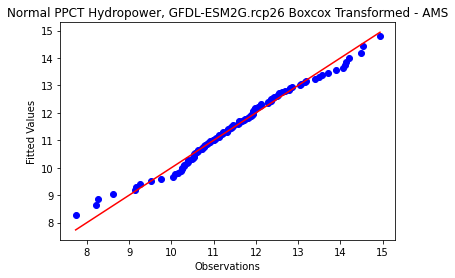

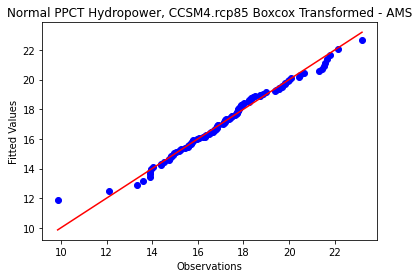

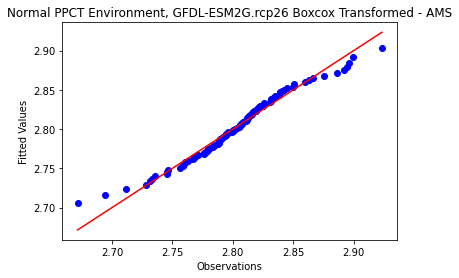

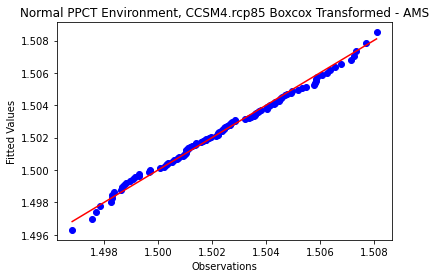

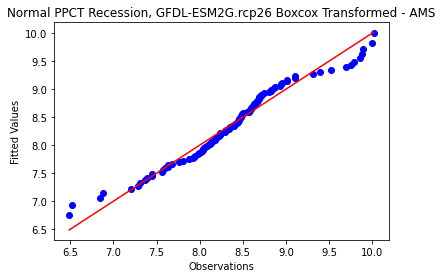

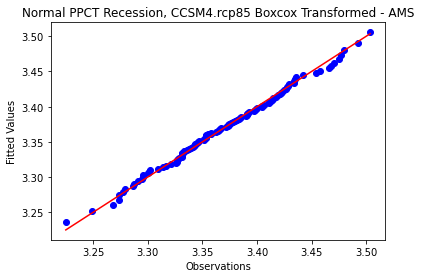

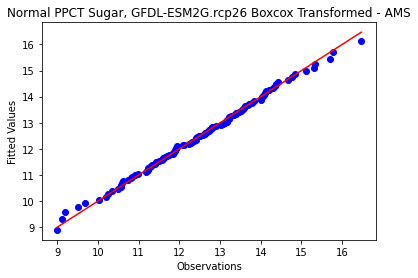

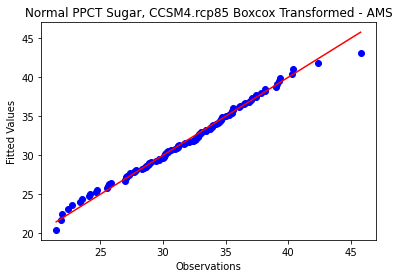

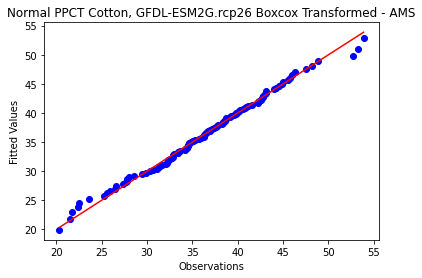

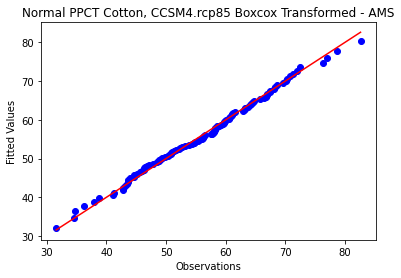

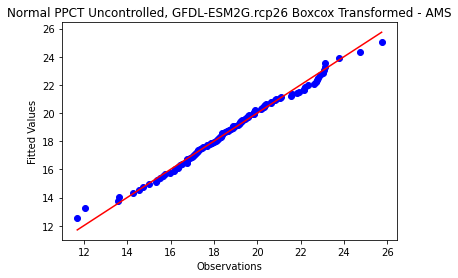

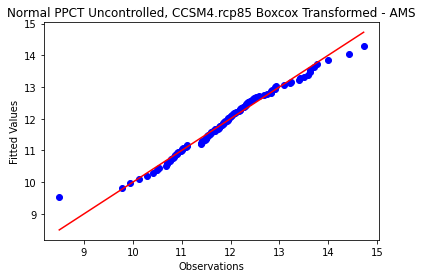

In [50]:
GFDL_bc_rhos = dict.fromkeys(Objectives)
GFDL_bc_p_vals = dict.fromkeys(Objectives)
CCSM_bc_rhos = dict.fromkeys(Objectives)
CCSM_bc_p_vals = dict.fromkeys(Objectives)
for col in Objectives:
    mu, sigma = utils.fitNormal(GFDL_bc[col],'MOM')
    rho, p_value = utils.NormalPPCT(GFDL_bc[col], mu, sigma, 'Normal PPCT %s, %s Boxcox Transformed - AMS' % (col, 'GFDL-ESM2G.rcp26'), '../Figures/NormalPPCT_BC_%s_%s_AMSfull.png'  % (col, 'GFDL-ESM2G.rcp26'))
    GFDL_bc_rhos[col] = rho
    GFDL_bc_p_vals[col] = p_value
    
    mu, sigma = utils.fitNormal(CCSM_bc[col],'MOM')
    rho, p_value = utils.NormalPPCT(CCSM_bc[col], mu, sigma, 'Normal PPCT %s, %s Boxcox Transformed - AMS' % (col, 'CCSM4.rcp85'), '../Figures/NormalPPCT_BC_%s_%s_AMSfull.png'  % (col, 'CCSM5.rcp85'))
    CCSM_bc_rhos[col] = rho
    CCSM_bc_p_vals[col] = p_value

In [51]:
print(GFDL_bc_p_vals)
print(CCSM_bc_p_vals)

{'Hydropower': 0.23299999999999998, 'Environment': 0.03720000000000001, 'Recession': 0.013599999999999945, 'Sugar': 0.9988, 'Cotton': 0.8107, 'Uncontrolled': 0.6464}
{'Hydropower': 0.18310000000000004, 'Environment': 0.8649, 'Recession': 0.9816, 'Sugar': 0.7361, 'Cotton': 0.9682, 'Uncontrolled': 0.09599999999999997}


Try log transformation

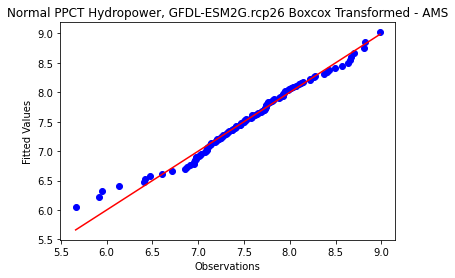

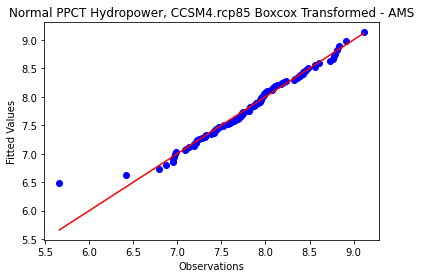

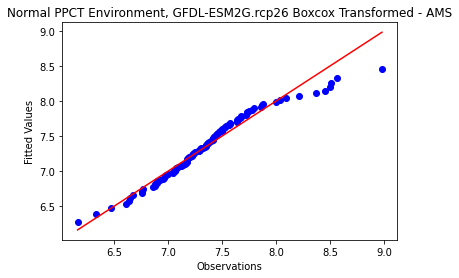

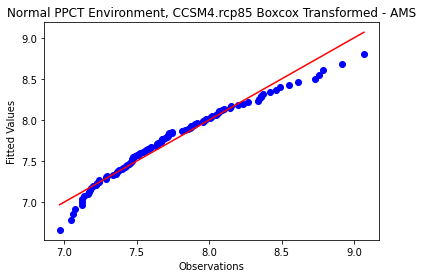

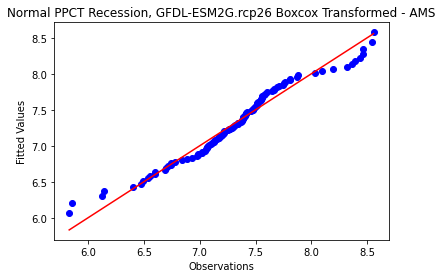

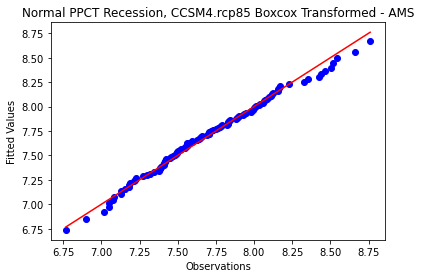

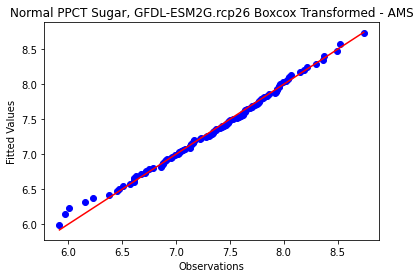

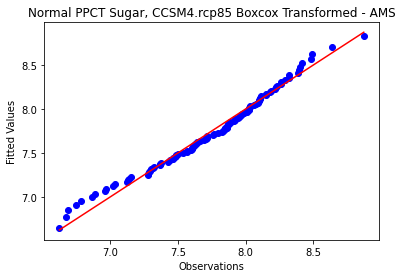

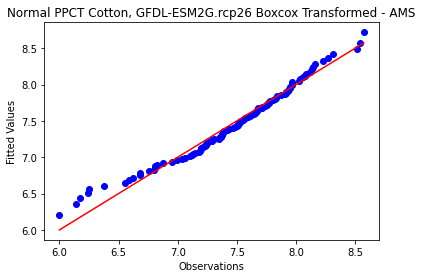

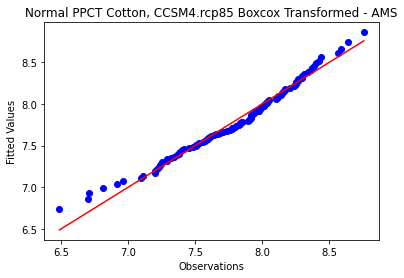

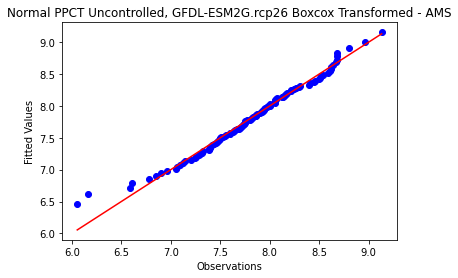

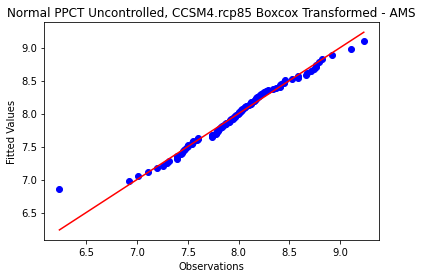

In [52]:
GFDL_log = np.log(GFDL_maxQ)
CCSM_log = np.log(CCSM_maxQ)

GFDL_log_p_vals = dict.fromkeys(Objectives)
CCSM_log_p_vals = dict.fromkeys(Objectives)
for col in Objectives:
    mu, sigma = utils.fitNormal(GFDL_log[col],'MOM')
    rho, p_value = utils.NormalPPCT(GFDL_log[col], mu, sigma, 'Normal PPCT %s, %s Boxcox Transformed - AMS' % (col, 'GFDL-ESM2G.rcp26'), '../Figures/NormalPPCT_log_%s_%s_AMSfull.png'  % (col, 'GFDL-ESM2G.rcp26'))
    GFDL_log_p_vals[col] = p_value
    
    mu, sigma = utils.fitNormal(CCSM_log[col],'MOM')
    rho, p_value = utils.NormalPPCT(CCSM_log[col], mu, sigma, 'Normal PPCT %s, %s Boxcox Transformed - AMS' % (col, 'CCSM4.rcp85'), '../Figures/NormalPPCT_log_%s_%s_AMSfull.png'  % (col, 'CCSM5.rcp85'))
    CCSM_log_p_vals[col] = p_value

In [53]:
print(GFDL_log_p_vals)
print(CCSM_log_p_vals)

{'Hydropower': 0.133, 'Environment': 0.0017000000000000348, 'Recession': 0.0131, 'Sugar': 0.8935, 'Cotton': 0.05800000000000005, 'Uncontrolled': 0.19269999999999998}
{'Hydropower': 0.03969999999999996, 'Environment': 0.007299999999999973, 'Recession': 0.6462, 'Sugar': 0.1956, 'Cotton': 0.13329999999999997, 'Uncontrolled': 0.058699999999999974}


These are worse than the boxcox transformed values. I will proceed with boxcox, but will be cautious with parametric tests for Environmental Flows and Flood Recession for the GFDL projection. 

### Test For Trend

Linear Model

In [54]:
GFDL_bc['Year'] = GFDL_bc.index
CCSM_bc['Year'] = CCSM_bc.index

GFDL_mod_dict = dict.fromkeys(Objectives)
CCSM_mod_dict = dict.fromkeys(Objectives)

for col in Objectives:
    mod = smf.ols(formula='%s ~ Year' %col, data=GFDL_bc)
    result = mod.fit()
    GFDL_mod_dict[col] = result
    mod = smf.ols(formula='%s ~ Year' %col, data=CCSM_bc)
    result = mod.fit()
    CCSM_mod_dict[col] = result
    
    
for col in Objectives:
    print(col, "GFDL")
    print(GFDL_mod_dict[col].summary())
    print(col, "CCSM")
    print(CCSM_mod_dict[col].summary())

Hydropower GFDL
                            OLS Regression Results                            
Dep. Variable:             Hydropower   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     2.587
Date:                Thu, 13 May 2021   Prob (F-statistic):              0.111
Time:                        09:55:17   Log-Likelihood:                -191.20
No. Observations:                 111   AIC:                             386.4
Df Residuals:                     109   BIC:                             391.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.1754      0.258    

##### Hydropower:
* Adj-R2 = 0.014 | 0.273
* p-value = 0.111 | 0.000


##### Environment:
* Adj-R2 = -0.008 | 0.466
* p-value = 0.686 | 0.000

##### Recession:
* Adj-R2 = -0.009 | 0.388
* p-value = 0.874 | 0.000

##### Sugarcane:
* Adj-R2 = -0.008 | 0.303
* p-value = 0.757 | 0.000

##### Cotton:
* Adj-R2 =  -0.009 | 0.271
* p-value = 0.870 | 0.000

##### Uncontrolled:
* Adj-R2 =  0.028 | 0.215
* p-value = 0.043 | 0.000

All have a significant trend for CCSM but not GFDL. GFDL does have a trend for uncontrolled, though. 

Now look at Mann Kendall Test:

In [55]:
GFDL_mk_dict = dict.fromkeys(Objectives)
CCSM_mk_dict = dict.fromkeys(Objectives)

for col in Objectives:
    trend, h, p, z = mk_test(np.array(GFDL_maxQ[col]))
    GFDL_mk_dict[col] = [trend,p]
    trend, h, p, z = mk_test(np.array(CCSM_maxQ[col]))
    CCSM_mk_dict[col] = [trend,p]

In [56]:
print(GFDL_mk_dict)
print(CCSM_mk_dict)

{'Hydropower': ['no trend', 0.12625636469955248], 'Environment': ['no trend', 0.504332974262915], 'Recession': ['no trend', 0.8865187169535913], 'Sugar': ['no trend', 0.6501052729560153], 'Cotton': ['no trend', 0.5526617754487824], 'Uncontrolled': ['increasing', 0.01591799449658793]}
{'Hydropower': ['increasing', 2.6731723501427496e-09], 'Environment': ['increasing', 6.439293542825908e-15], 'Recession': ['increasing', 3.788080960021034e-13], 'Sugar': ['increasing', 7.981015848201878e-11], 'Cotton': ['increasing', 1.359992785054942e-09], 'Uncontrolled': ['increasing', 1.0580614606681138e-08]}


### Change Points

KS test 

In [81]:
GFDL_maxQ

Hydropower  Environment  Recession   Sugar  Cotton  Uncontrolled
Year                                                                  
1989       287.6       1241.0     1116.0   795.1  1358.0        1809.0
1990      1043.0       1148.0     1322.0   854.0  1606.0        1819.0
1991      1246.0       1064.0     1182.0   959.8  1550.0        1469.0
1992      1599.0       1187.0     1156.0  1248.0  1393.0        2306.0
1993      1326.0       1461.0     1479.0  1266.0  1336.0        1911.0
...          ...          ...        ...     ...     ...           ...
2095      1965.0       1455.0     1440.0  2012.0  1876.0        2324.0
2096      1121.0       1052.0     1084.0  1565.0  1245.0        2186.0
2097      6797.0       2980.0     5124.0  4899.0  5283.0        6625.0
2098      2668.0       2638.0     2648.0  2803.0  2547.0        2580.0
2099      2758.0       2081.0     1960.0  2411.0  2496.0        4716.0

[111 rows x 6 columns]

Hydropower
Environment
Recession
Sugar
Cotton
Uncontrolled


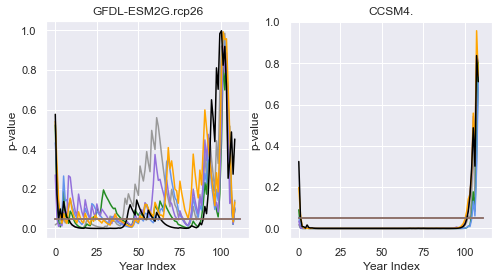

In [80]:
GFDL_ks_pvals = dict.fromkeys(Objectives)
CCSM_ks_pvals = dict.fromkeys(Objectives)

def ks_test(df, col):
    p_values = np.ones(len(df[col]) -1)
    for i in range(len(df[col]) - 1):
        _, p_values[i] = ss.ks_2samp(df[col].iloc[0:(i+1)],df[col].iloc[(i+1)::])
    return p_values

for col in Objectives:
    GFDL_ks_pvals[col] = ks_test(GFDL_maxQ, col)
    CCSM_ks_pvals[col] = ks_test(CCSM_maxQ, col)

fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(8,4)
for col in Objectives:
    print(col)
    ax1.plot(GFDL_ks_pvals[col][0:-1], color = col_dict[col])
    ax1.plot([0,len(GFDL_maxQ.index)],[0.05,0.05])
    ax1.set_ylabel("p-value")
    ax1.set_xlabel("Year Index")
    ax1.set_title("GFDL-ESM2G.rcp26")
    ax2.plot(CCSM_ks_pvals[col][0:-1], color = col_dict[col])
    ax2.plot([0,len(CCSM_maxQ.index)],[0.05,0.05])
    ax2.set_ylabel("p-value")
    ax2.set_xlabel("Year Index")
    ax2.set_title("CCSM4.")
plt.show()

CCSM shows change poins for all policies for most of the the time. 

GFDL has two phases of potential change points, both in historical time period and from climate change period of record.

Wilcoxon Rank sum test:

Hydropower
Environment
Recession
Sugar
Cotton
Uncontrolled


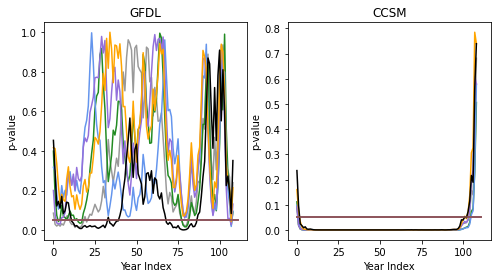

In [58]:
GFDL_wc_pvals = dict.fromkeys(Objectives)
CCSM_wc_pvals = dict.fromkeys(Objectives)

for col in Objectives:
    p_values = np.ones(len(GFDL_maxQ[col]) -1)
    for i in range(len(GFDL_maxQ[col]) - 1):
        _, p_values[i] = ss.ranksums(GFDL_maxQ[col].iloc[0:(i+1)],GFDL_maxQ[col].iloc[(i+1)::])
    GFDL_wc_pvals[col] = p_values
    p_values = np.ones(len(CCSM_maxQ[col]) -1)
    for i in range(len(CCSM_maxQ[col]) - 1):
        _, p_values[i] = ss.ranksums(CCSM_maxQ[col].iloc[0:(i+1)],CCSM_maxQ[col].iloc[(i+1)::])
    CCSM_wc_pvals[col] = p_values    


fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(8,4)
for col in Objectives:
    print(col)
    ax1.plot(GFDL_wc_pvals[col][0:-1], color = col_dict[col])
    ax1.plot([0,len(GFDL_maxQ.index)],[0.05,0.05])
    ax1.set_ylabel("p-value")
    ax1.set_xlabel("Year Index")
    ax1.set_title("GFDL")
    ax2.plot(CCSM_wc_pvals[col][0:-1], color = col_dict[col])
    ax2.plot([0,len(CCSM_maxQ.index)],[0.05,0.05])
    ax2.set_ylabel("p-value")
    ax2.set_xlabel("Year Index")
    ax2.set_title("CCSM")
plt.show()

Similar, but less likely to have chnage points for reservoir operating policies than uncontrolled for GFDL.

Linear model with boxcox transformed data:

Hydropower
Environment
Recession
Sugar
Cotton
Uncontrolled


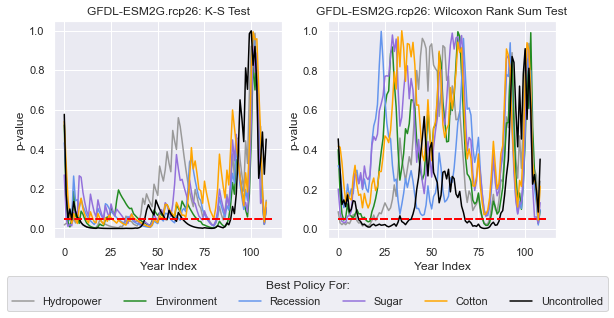

In [92]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(9,4)
for col in Objectives:
    print(col)
    ax1.plot(GFDL_ks_pvals[col][0:-1], color = col_dict[col], label=col)
    ax1.plot([0,len(GFDL_maxQ.index)],[0.05,0.05], color="red", linestyle="dashed", lw=2)
    ax1.set_ylabel("p-value")
    ax1.set_xlabel("Year Index")
    ax1.set_title("GFDL-ESM2G.rcp26: K-S Test")
    ax2.plot(GFDL_wc_pvals[col][0:-1], color = col_dict[col],label=col)
    ax2.plot([0,len(GFDL_maxQ.index)],[0.05,0.05], color="red", linestyle="dashed", lw=2)
    ax2.set_ylabel("p-value")
    ax2.set_xlabel("Year Index")
    ax2.set_title("GFDL-ESM2G.rcp26: Wilcoxon Rank Sum Test")
plt.legend(ncol = 6, bbox_to_anchor=(1.25,-.15), title="Best Policy For:")

plt.savefig('../Figures/Wet_GFDL_ChangePoints.png', bbox_inches="tight")

plt.show()

Hydropower
Environment
Recession
Sugar
Cotton
Uncontrolled


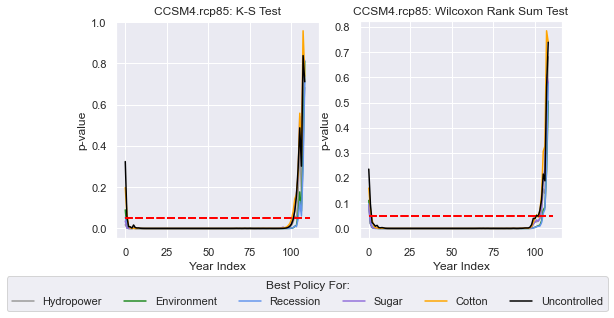

In [93]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(8,4)
for col in Objectives:
    print(col)
    ax1.plot(CCSM_ks_pvals[col][0:-1], color = col_dict[col], label=col)
    ax1.plot([0,len(GFDL_maxQ.index)],[0.05,0.05], color="red", linestyle="dashed", lw=2)
    ax1.set_ylabel("p-value")
    ax1.set_xlabel("Year Index")
    ax1.set_title("CCSM4.rcp85: K-S Test")
    ax2.plot(CCSM_wc_pvals[col][0:-1], color = col_dict[col],label=col)
    ax2.plot([0,len(CCSM_maxQ.index)],[0.05,0.05], color="red", linestyle="dashed", lw=2)
    ax2.set_ylabel("p-value")
    ax2.set_xlabel("Year Index")
    ax2.set_title("CCSM4.rcp85: Wilcoxon Rank Sum Test")
plt.legend(ncol = 6, bbox_to_anchor=(1.25,-.15), title="Best Policy For:")

plt.savefig('../Figures/Wet_CCSM_ChangePoints.png', bbox_inches="tight")
plt.show()

In [79]:
GFDL_lm_pvals = dict.fromkeys(Objectives)
CCSM_lm_pvals = dict.fromkeys(Objectives)


for col in Objectives:
    GFDL_bc['Dummy'] = np.ones(len(GFDL_bc.index))
    p_values = np.ones(len(GFDL_bc.index))
    mod = smf.ols(formula='%s ~ Dummy' % col, data=GFDL_bc)
    result = mod.fit()
    p_values[0] = result.pvalues[1]
    for i in range(len(p_values)):
        GFDL_bc['Dummy'][1989+i] = 0
        mod = smf.ols(formula='%s ~ Dummy' % col, data=GFDL_bc)
        result = mod.fit()
        p_values[i] = result.pvalues[1]
    GFDL_lm_pvals[col] = p_values
    

<ipython-input-79-5910780d6456>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GFDL_bc['Dummy'][1989+i] = 0
<ipython-input-79-5910780d6456>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GFDL_bc['Dummy'][1989+i] = 0
<ipython-input-79-5910780d6456>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GFDL_bc['Dummy'][1989+i] = 0
<ipython-input-79-5910780d6456>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

In [60]:
for col in Objectives:
    CCSM_bc['Dummy'] = np.ones(len(CCSM_bc.index))
    p_values = np.ones(len(CCSM_bc.index))
    mod = smf.ols(formula='%s ~ Dummy' % col, data=CCSM_bc)
    result = mod.fit()
    p_values[0] = result.pvalues[1]
    for i in range(len(p_values)):
        CCSM_bc['Dummy'][1989+i] = 0
        mod = smf.ols(formula='%s ~ Dummy' % col, data=CCSM_bc)
        result = mod.fit()
        p_values[i] = result.pvalues[1]
    CCSM_lm_pvals[col] = p_values
    

<ipython-input-60-37be9911466e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CCSM_bc['Dummy'][1989+i] = 0
<ipython-input-60-37be9911466e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CCSM_bc['Dummy'][1989+i] = 0
<ipython-input-60-37be9911466e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CCSM_bc['Dummy'][1989+i] = 0
<ipython-input-60-37be9911466e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

### Check for a trend in the residuals from linear models 

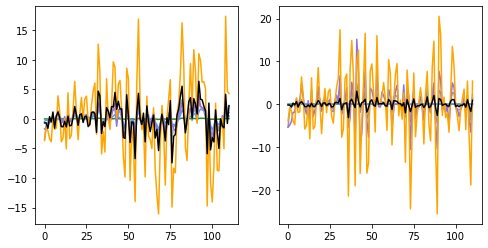

In [61]:
fig, (ax1,ax2) = plt.subplots(1,2)
fig.set_size_inches(8,4)
for col in Objectives:
    ax1.plot(GFDL_mod_dict[col].resid, color=col_dict[col])
    ax2.plot(CCSM_mod_dict[col].resid, color=col_dict[col])

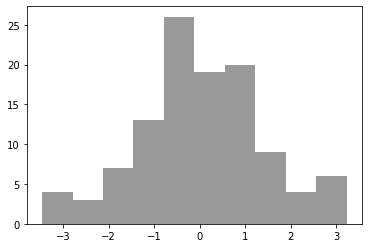

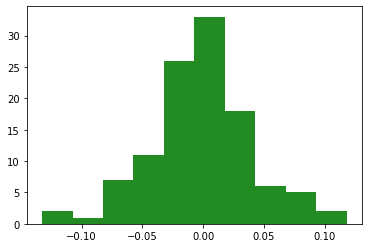

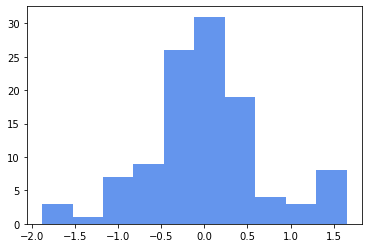

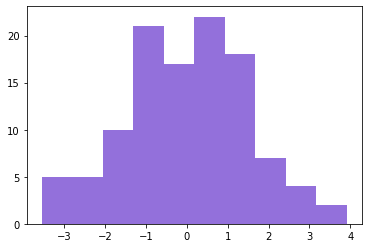

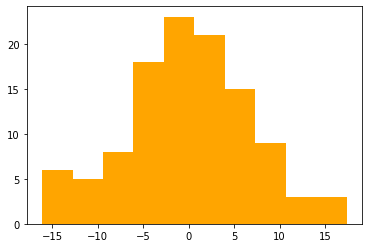

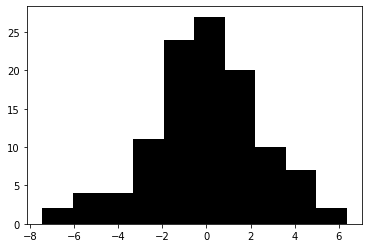

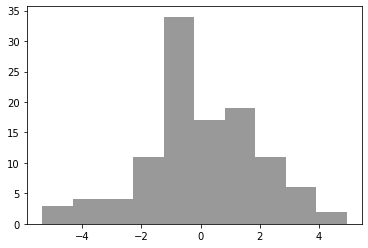

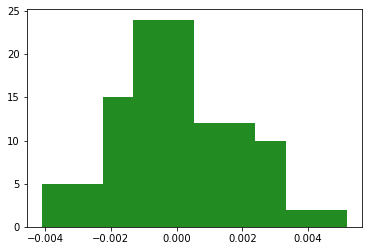

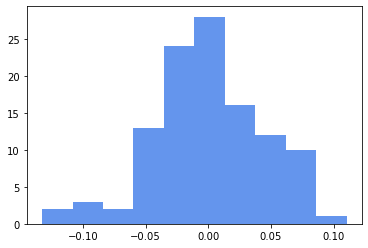

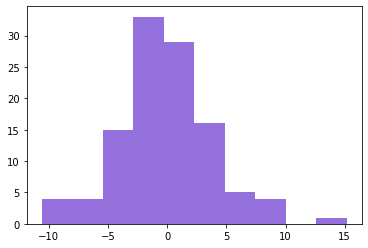

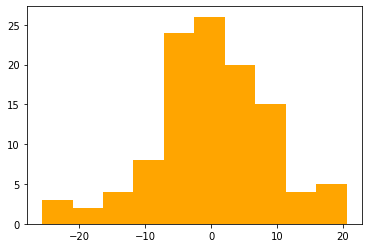

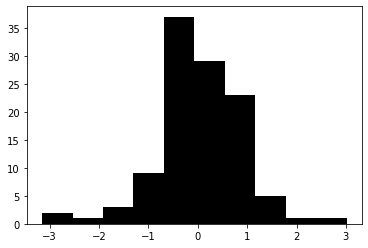

In [62]:
for col in Objectives:
    plt.hist(GFDL_mod_dict[col].resid, color=col_dict[col])
    plt.show()
    
for col in Objectives:
    plt.hist(CCSM_mod_dict[col].resid, color=col_dict[col])
    plt.show()

Test normality of residuals

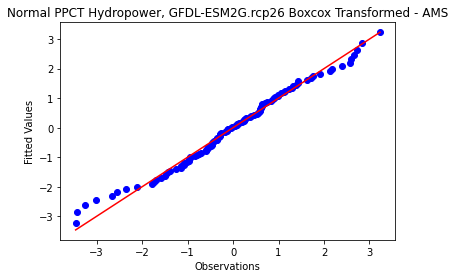

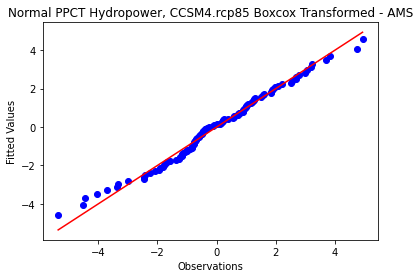

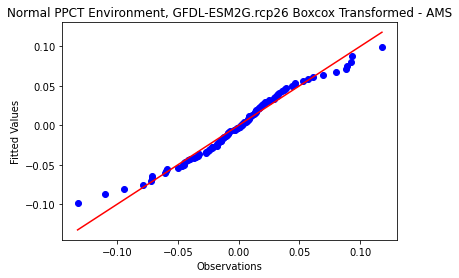

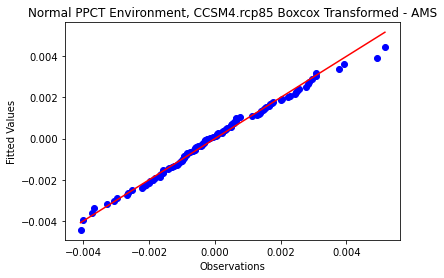

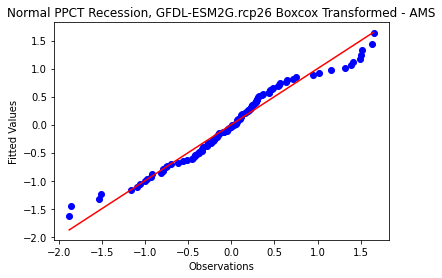

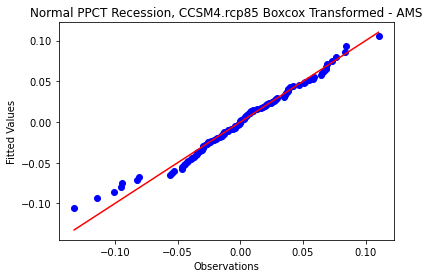

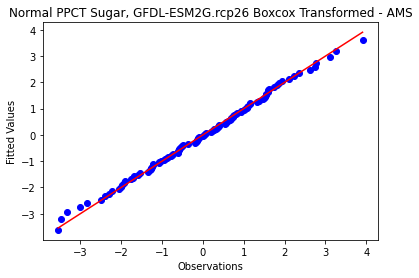

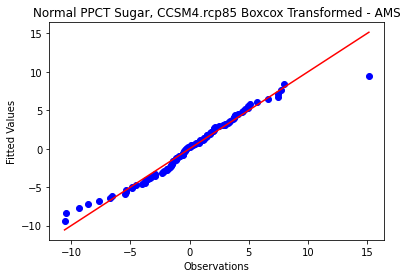

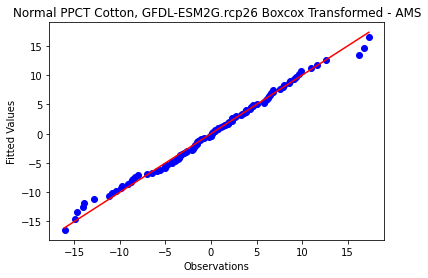

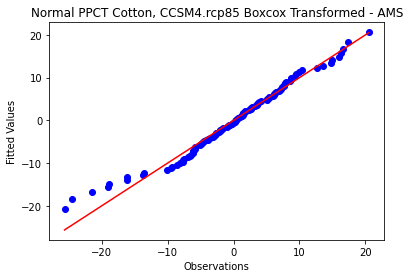

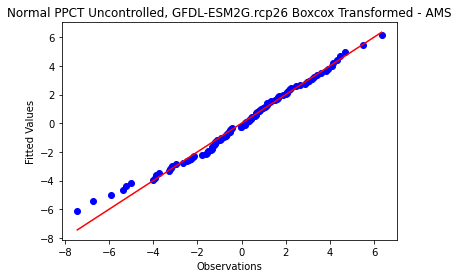

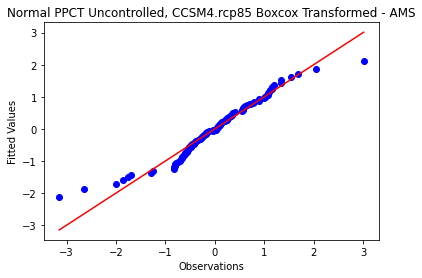

In [63]:
GFDL_resid_p_vals = dict.fromkeys(Objectives)
CCSM_resid_p_vals = dict.fromkeys(Objectives)
for col in Objectives:
    mu, sigma = utils.fitNormal(GFDL_mod_dict[col].resid,'MOM')
    rho, p_value = utils.NormalPPCT(GFDL_mod_dict[col].resid, mu, sigma, 'Normal PPCT %s, %s Boxcox Transformed - AMS' % (col, 'GFDL-ESM2G.rcp26'), '../Figures/NormalPPCT_resid_%s_%s_AMS.png'  % (col, 'GFDL-ESM2G.rcp26'))
    GFDL_resid_p_vals[col] = p_value
    
    mu, sigma = utils.fitNormal(CCSM_mod_dict[col].resid,'MOM')
    rho, p_value = utils.NormalPPCT(CCSM_mod_dict[col].resid, mu, sigma, 'Normal PPCT %s, %s Boxcox Transformed - AMS' % (col, 'CCSM4.rcp85'), '../Figures/NormalPPCT_resid_%s_%s_AMS.png'  % (col, 'CCSM5.rcp85'))
    CCSM_resid_p_vals[col] = p_value

In [64]:
print(GFDL_resid_p_vals)
print(CCSM_resid_p_vals)

{'Hydropower': 0.34209999999999996, 'Environment': 0.030100000000000016, 'Recession': 0.013599999999999945, 'Sugar': 0.996, 'Cotton': 0.7633, 'Uncontrolled': 0.3378}
{'Hydropower': 0.3439, 'Environment': 0.5232, 'Recession': 0.17830000000000001, 'Sugar': 0.01090000000000002, 'Cotton': 0.07299999999999995, 'Uncontrolled': 0.0021999999999999797}


In [65]:
GFDL_resid_bc = pd.DataFrame()
CCSM_resid_bc = pd.DataFrame()

GFDL_resid_lambdas = dict.fromkeys(Objectives)
CCSM_resid_lambdas = dict.fromkeys(Objectives)

for col in Objectives:
    Q_T, llambda = ss.boxcox(GFDL_mod_dict[col].resid - GFDL_mod_dict[col].resid.min() + 0.1)
    GFDL_resid_lambdas[col] = llambda
    GFDL_resid_bc[col] = Q_T
    Q_T, llambda = ss.boxcox(CCSM_mod_dict[col].resid - CCSM_mod_dict[col].resid.min() + 0.1)
    CCSM_resid_bc[col] = Q_T  
    CCSM_resid_lambdas[col] == llambda

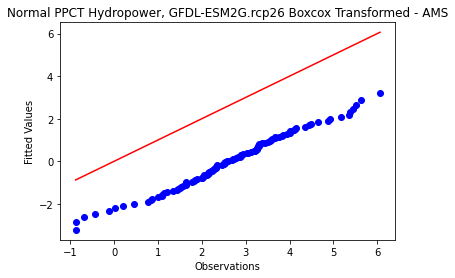

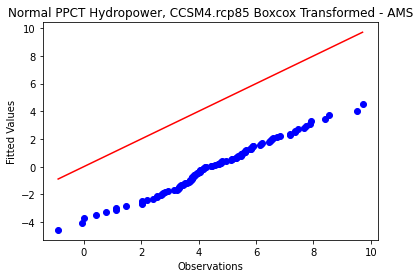

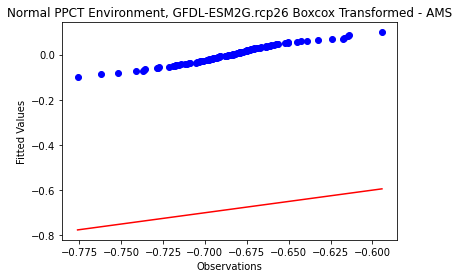

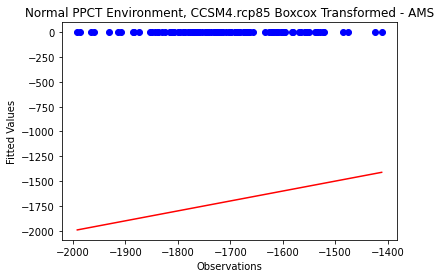

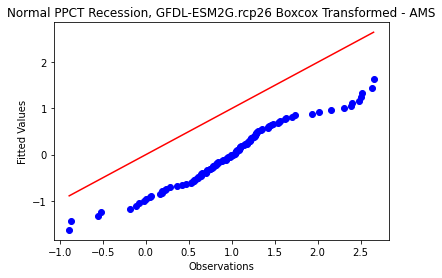

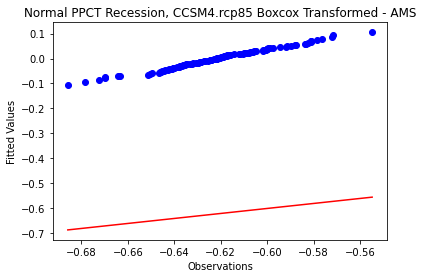

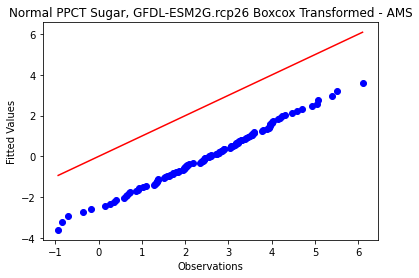

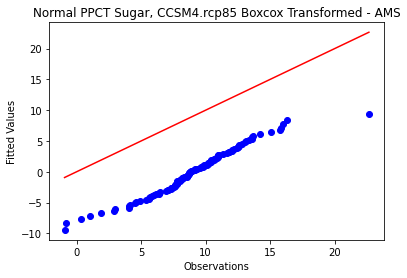

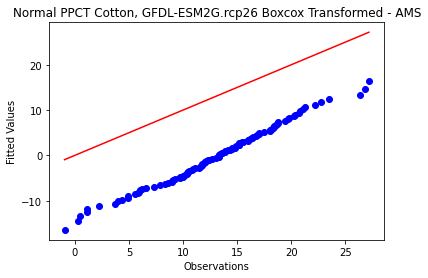

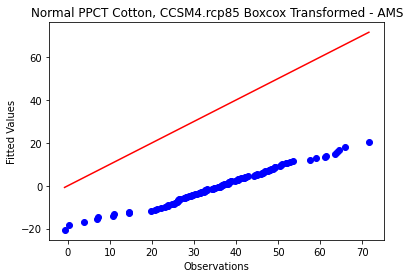

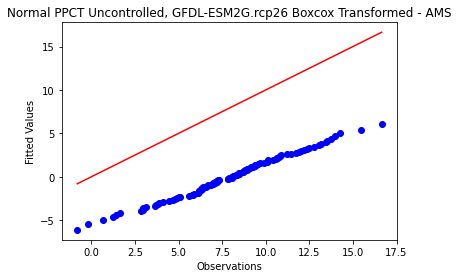

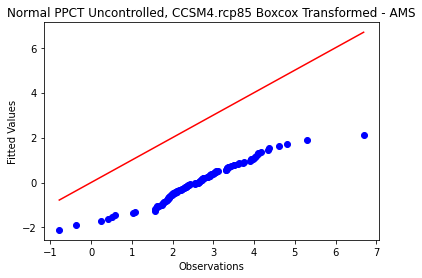

In [66]:
GFDL_residBC_p_vals = dict.fromkeys(Objectives)
CCSM_residBC_p_vals = dict.fromkeys(Objectives)
for col in Objectives:
    mu, sigma = utils.fitNormal(GFDL_mod_dict[col].resid,'MOM')
    rho, p_value = utils.NormalPPCT(GFDL_resid_bc[col], mu, sigma, 'Normal PPCT %s, %s Boxcox Transformed - AMS' % (col, 'GFDL-ESM2G.rcp26'), '../Figures/NormalPPCT_residBC_%s_%s_AMS.png'  % (col, 'GFDL-ESM2G.rcp26'))
    GFDL_residBC_p_vals[col] = p_value
    
    mu, sigma = utils.fitNormal(CCSM_mod_dict[col].resid,'MOM')
    rho, p_value = utils.NormalPPCT(CCSM_resid_bc[col], mu, sigma, 'Normal PPCT %s, %s Boxcox Transformed - AMS' % (col, 'CCSM4.rcp85'), '../Figures/NormalPPCT_residBC_%s_%s_AMS.png'  % (col, 'CCSM5.rcp85'))
    CCSM_residBC_p_vals[col] = p_value

Use untransformed residuals, caution for parametric tests. 

Start with nonparametric tests:

Mann Kendall

In [67]:
GFDL_mkResid_dict = dict.fromkeys(Objectives)
CCSM_mkResid_dict = dict.fromkeys(Objectives)

for col in Objectives:
    trend, h, p, z = mk_test(np.array(GFDL_mod_dict[col].resid))
    GFDL_mkResid_dict[col] = [trend,p]
    trend, h, p, z = mk_test(np.array(CCSM_mod_dict[col].resid))
    CCSM_mkResid_dict[col] = [trend,p]

In [68]:
print(GFDL_mkResid_dict) 
print(CCSM_mkResid_dict) 


{'Hydropower': ['no trend', 0.9796690089892122], 'Environment': ['no trend', 0.7792299813325714], 'Recession': ['no trend', 0.9959333792824665], 'Sugar': ['no trend', 0.8664309874873253], 'Cotton': ['no trend', 0.6537806780358599], 'Uncontrolled': ['no trend', 0.5577887220616029]}
{'Hydropower': ['no trend', 0.7136430205287467], 'Environment': ['no trend', 0.8185930952884788], 'Recession': ['no trend', 0.8146343540541845], 'Sugar': ['no trend', 0.7442778686133489], 'Cotton': ['no trend', 0.7949134959680269], 'Uncontrolled': ['no trend', 0.9552904017631008]}


In [69]:
GFDL_resids = pd.DataFrame()
CCSM_resids = pd.DataFrame()
for col in Objectives:
    GFDL_resids[col] = GFDL_mod_dict[col].resid
    CCSM_resids[col] = CCSM_mod_dict[col].resid
    
CCSM_resids.index = [f for f in range(1989,2100)]
GFDL_resids.index = [f for f in range(1989,2100)]

In [70]:
GFDL_resids['Year'] = GFDL_resids.index
CCSM_resids['Year'] = CCSM_resids.index

GFDL_ResidMod = dict.fromkeys(Objectives)
CCSM_ResidMod = dict.fromkeys(Objectives)

for col in Objectives:
    mod = smf.ols(formula='%s ~ Year' %col, data=GFDL_resids)
    result = mod.fit()
    GFDL_ResidMod[col] = result
    mod = smf.ols(formula='%s ~ Year' %col, data=CCSM_resids)
    result = mod.fit()
    CCSM_ResidMod[col] = result
    
    
for col in Objectives:
    print(col, "GFDL")
    print(GFDL_ResidMod[col].summary())
    print(col, "CCSM")
    print(CCSM_ResidMod[col].summary())

Hydropower GFDL
                            OLS Regression Results                            
Dep. Variable:             Hydropower   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                 1.521e-14
Date:                Thu, 13 May 2021   Prob (F-statistic):               1.00
Time:                        09:56:11   Log-Likelihood:                -191.20
No. Observations:                 111   AIC:                             386.4
Df Residuals:                     109   BIC:                             391.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.509e-13      8.279   3

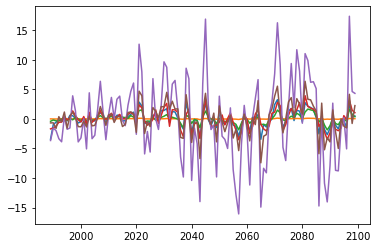

In [71]:
for col in Objectives:
    plt.plot(GFDL_resids[col])